# **Descargas Atmósfericas - Inteligencia Artificial**

* Leer los archivos de incidencia de rayos para Asunción, Central, Ñeembucu y Concepción.
* Leer el archivo de temperatura y humedad interpolado de Asunción.
* Combinar estos conjuntos de datos en una sola serie temporal, asegurándonos de que estén alineados en el tiempo.
* Explorar y preparar el conjunto de datos para el modelo de predicción

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* **Serie Temporal 1:** Incidencias de rayos (positivas y negativas) para Asunción y Central en conjunto con los datos de temperatura y humedad.
* **Serie Temporal 2:** Incidencias de rayos (separadas por polaridad) para Asunción y Central, y también para Concepción y Ñeembucu.
* **Serie Temporal 3:** Integración de todos los datos en conjunto.

# **Librerias utilizadas**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import unsignedinteger
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
print(tf.__version__)
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

2.15.0


In [ ]:
# Rutas de los archivos
ruta_temp_humedad = '/content/drive/MyDrive/2.TPInteligenciaArtificial/Procesados/Temp_Asu20092021_interpolado.csv'
rutas_rayos = {
    'Asuncion': '/content/drive/MyDrive/2.TPInteligenciaArtificial/Procesados/final_merged_Asuncion.csv',
    'Central': '/content/drive/MyDrive/2.TPInteligenciaArtificial/Procesados/final_merged_Central.csv',
    'Ñeembucu': '/content/drive/MyDrive/2.TPInteligenciaArtificial/Procesados/final_merged_Neembucu.csv',
    'Concepcion': '/content/drive/MyDrive/2.TPInteligenciaArtificial/Procesados/final_merged_Concepcion.csv'
}

# Leer y preparar el archivo de temperatura y humedad
df_temp_humedad = pd.read_csv(ruta_temp_humedad, index_col='Fecha', parse_dates=True)

# Leer y preparar los archivos de incidencia de rayos, sumando las incidencias por periodo
df_rayos = pd.DataFrame(index=df_temp_humedad.index)
for nombre, ruta in rutas_rayos.items():
    df_temp = pd.read_csv(ruta, index_col='timestamp', parse_dates=True)
    # Aquí asumimos que el archivo ya está en la frecuencia deseada, o puedes ajustarlo según sea necesario
    df_temp_resampled = df_temp.resample('30T').size()  # Cambiar '30T' para tener otra frecuencia
    df_rayos[nombre] = df_temp_resampled

# Combinar los datos de temperatura, humedad con los datos de incidencia de rayos
df_final = pd.concat([df_temp_humedad, df_rayos], axis=1)

# Ahora df_final contiene tanto los datos de temperatura y humedad como la cantidad de rayos por periodo para cada ubicación


In [ ]:
df_final=df_final.drop(columns=['Unnamed: 0'])
print(df_final)
df_final.describe()

                     Temperatura    Humedad  Asuncion  Central  Ñeembucu  \
Fecha                                                                      
2009-01-01 00:00:00    26.749483  69.609451       NaN      NaN       NaN   
2009-01-01 00:30:00    26.617255  71.045404       NaN      NaN       NaN   
2009-01-01 01:00:00    26.485027  72.481356       NaN      NaN       NaN   
2009-01-01 01:30:00    26.352799  73.917309       NaN      NaN       NaN   
2009-01-01 02:00:00    26.220570  75.353261       NaN      NaN       NaN   
...                          ...        ...       ...      ...       ...   
2021-12-31 19:00:00    40.044972  20.861568       1.0      1.0       1.0   
2021-12-31 19:30:00    39.445101  21.314759       1.0      1.0       1.0   
2021-12-31 20:00:00    38.845231  21.767949       1.0      1.0       1.0   
2021-12-31 20:30:00    38.245361  22.221140       1.0      1.0       1.0   
2021-12-31 21:00:00    37.645491  22.674331       1.0      1.0       1.0   

           

Temperatura        Humedad  Asuncion   Central  Ñeembucu  Concepcion
count  227899.000000  227899.000000  105210.0  105210.0  105065.0    105209.0
mean       23.331657      69.583280       1.0       1.0       1.0         1.0
std         6.873175      20.724818       0.0       0.0       0.0         0.0
min         0.816554      11.362540       1.0       1.0       1.0         1.0
25%        18.915899      53.700014       1.0       1.0       1.0         1.0
50%        23.506668      71.937126       1.0       1.0       1.0         1.0
75%        27.962949      87.885599       1.0       1.0       1.0         1.0
max        45.408000     113.593546       1.0       1.0       1.0         1.0

# Tratar Valores Atípicos:

* Para temperatura y humedad, reemplazaremos los valores atípicos con la media de la serie.
* Para el conteo de incidencias de rayos, reemplazaremos los valores atípicos altos (definidos como aquellos significativamente más altos que la media) con la media calculada de los valores distintos de cero.
* Generar Series Temporales para el periodo de análisis.

In [ ]:
def tratar_valores_atipicos(df, columnas):
  for col in columnas:
    df_filtered = df[df[col] > 0]  # Seleccionamos valores mayores a cero
    media = df_filtered[col].mean()
    desviacion_std = df[col].std()
    umbral_superior = media + 1 * desviacion_std
    # Para temperatura y humedad, reemplazamos los atípicos con la media
    if col in ['Temperatura', 'Humedad']:
      df[col] = df[col].mask((df[col] > 2.5*umbral_superior) | (df[col] < media - 3 * desviacion_std), media)
    # Para rayos, consideramos solo los valores altos atípicos y distintos de cero
    else:
      df[col] = df[col].mask(df[col] > umbral_superior, media)
  return df

###Carga y Preparación de Datos

In [ ]:
# Rutas de archivos
ruta_base = '/content/drive/MyDrive/2.TPInteligenciaArtificial/Procesados/'
archivos_rayos = {
    'Asuncion': 'final_merged_Asuncion.csv',
    'Central': 'final_merged_Central.csv',
    'Ñeembucu': 'final_merged_Neembucu.csv',
    'Concepcion': 'final_merged_Concepcion.csv'
}
ruta_temp_humedad = ruta_base + 'Temp_Asu20092021_interpolado.csv'

# Cargar y preparar los archivos de temperatura y humedad
df_temp_humedad = pd.read_csv(ruta_temp_humedad, index_col='Fecha', parse_dates=True)

# Cargar y preparar los archivos de incidencia de rayos
df_rayos = {}
for lugar, archivo in archivos_rayos.items():
    df_rayos[lugar] = pd.read_csv(ruta_base + archivo, index_col='timestamp', parse_dates=True)
    df_rayos[lugar]= df_rayos[lugar].fillna(0)

In [ ]:
print(df_rayos['Concepcion'][16:100].describe())

         Positivo    Negativo
count   84.000000   84.000000
mean    13.178571   13.642857
std     72.751295   76.388929
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      0.000000    0.000000
max    524.000000  587.000000


In [ ]:
# Cargar los archivos y aplicar el tratamiento de valores atípicos
df_temp_humedad = pd.read_csv(ruta_temp_humedad, index_col='Fecha', parse_dates=True)
df_temp_humedad = df_temp_humedad['2016':'2019']
df_temp_humedad = tratar_valores_atipicos(df_temp_humedad, ['Temperatura', 'Humedad'])
df_aux= df_temp_humedad
df_temp_humedad=pd.DataFrame()
df_temp_humedad['Temperatura']=df_aux['Temperatura']
df_temp_humedad['Humedad']=df_aux['Humedad']
df_rayos = {}
for lugar, archivo in archivos_rayos.items():
    df_temp = pd.read_csv(ruta_base + archivo, index_col='timestamp', parse_dates=True)
    df_temp = df_temp['2016':'2019']
    df_temp = tratar_valores_atipicos(df_temp, ['Positivo', 'Negativo'])
    df_rayos[lugar] = df_temp.fillna(0)

<ipython-input-4-cc5a13df382d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].mask(df[col] > umbral_superior, media)


In [ ]:
df_final

Temperatura    Humedad  Asuncion  Central  Ñeembucu  \
Fecha                                                                      
2009-01-01 00:00:00    26.749483  69.609451       NaN      NaN       NaN   
2009-01-01 00:30:00    26.617255  71.045404       NaN      NaN       NaN   
2009-01-01 01:00:00    26.485027  72.481356       NaN      NaN       NaN   
2009-01-01 01:30:00    26.352799  73.917309       NaN      NaN       NaN   
2009-01-01 02:00:00    26.220570  75.353261       NaN      NaN       NaN   
...                          ...        ...       ...      ...       ...   
2021-12-31 19:00:00    40.044972  20.861568       1.0      1.0       1.0   
2021-12-31 19:30:00    39.445101  21.314759       1.0      1.0       1.0   
2021-12-31 20:00:00    38.845231  21.767949       1.0      1.0       1.0   
2021-12-31 20:30:00    38.245361  22.221140       1.0      1.0       1.0   
2021-12-31 21:00:00    37.645491  22.674331       1.0      1.0       1.0   

                     Concepcion  
Fecha                            
2009-01-01 00:00:00         NaN  
2009-01-01 00:30:00         NaN  
2009-01-01 01:00:00         NaN  
2009-01-01 01:30:00         NaN  
2009-01-01 02:00:00         NaN  
...                         ...  
2021-12-31 19:00:00         1.0  
2021-12-31 19:30:00         1.0  
2021-12-31 20:00:00         1.0  
2021-12-31 20:30:00         1.0  
2021-12-31 21:00:00         1.0  

[227899 rows x 6 columns]

In [ ]:
for lugar, df in df_rayos.items():
    df_rayos[lugar] = df.fillna(0)
    print(df.describe())

df_rayos['Neembucu'] = df_rayos.pop('Ñeembucu')

           Positivo      Negativo
count  70127.000000  70127.000000
mean       0.393632      0.460413
std        3.925384      4.320772
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.000000
max       82.000000     76.000000
           Positivo      Negativo
count  70127.000000  70127.000000
mean       0.463122      0.509164
std        4.992118      4.865150
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.000000
max      119.000000     92.000000
           Positivo      Negativo
count  69982.000000  69982.000000
mean       0.473391      0.492643
std        4.430278      4.197744
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.000000
max       83.000000     68.000000
           Positivo      Negativo
count  70126.000000  70126.000000
mean       0.4

In [ ]:
print(df_rayos)

{'Asuncion':                      Positivo  Negativo
timestamp                              
2016-01-01 00:30:00       2.0       1.0
2016-01-01 01:00:00       2.0       2.0
2016-01-01 01:30:00       0.0       0.0
2016-01-01 02:00:00       0.0       0.0
2016-01-01 02:30:00       0.0       0.0
...                       ...       ...
2019-12-31 21:30:00       0.0       0.0
2019-12-31 22:00:00       0.0       0.0
2019-12-31 22:30:00       0.0       0.0
2019-12-31 23:00:00       0.0       0.0
2019-12-31 23:30:00       0.0       0.0

[70127 rows x 2 columns], 'Central':                      Positivo  Negativo
timestamp                              
2016-01-01 00:30:00       1.0       0.0
2016-01-01 01:00:00       2.0       0.0
2016-01-01 01:30:00       0.0       0.0
2016-01-01 02:00:00       2.0       0.0
2016-01-01 02:30:00       0.0       2.0
...                       ...       ...
2019-12-31 21:30:00       0.0       0.0
2019-12-31 22:00:00       0.0       0.0
2019-12-31 22:30:00       0.0

### Starnet load

 * Identificar la fecha de inicio más tardía entre todos los DataFrames.

* Recortar cada DataFrame para que comiencen desde esa fecha de inicio más tardía.

In [ ]:
data_path = "/content/drive/MyDrive/2.TPInteligenciaArtificial/Organizado/Startnet/resampled"

ubicaciones = {
    'Asuncion': (-25.301478, -57.536707),
    'Central': (-25.5628115, -57.5079912),
    'Ñeembucu': (-26.648707, -58.107135),
    'Concepcion': (-23.434573, -57.434246)
}

# Extensiones de los archivos
file_extension_1 = "(minus).csv"
file_extension_2 = "(plus).csv"
# Frecuencia de resampleo
resample_freq = "30T"
pol=['Negativo', 'Positivo']
polaridad=['minus', 'plus']
# Nombre de la nueva columna
locality_column = "Localidad"

In [ ]:
starnet_dfs=pd.DataFrame()

for ubicacion in ubicaciones:
  for sign in pol:
    polaridad= 'minus'
    if sign=='Positivo':
      polaridad='plus'
    path_startnet = os.path.join(data_path, f"{ubicacion}_resampl_{sign}.csv")
    df = pd.read_csv(path_startnet, index_col='timestamp', parse_dates=True)
    if ubicacion=='Ñeembucu':
      starnet_dfs[f"Neembucu_{sign}_snet"]=df[f'{ubicacion}_{sign}']
      starnet_dfs[f"Neembucu_{sign}_snet"]=starnet_dfs[f"Neembucu_{sign}_snet"].fillna(0)

    else:
      starnet_dfs[f"{ubicacion}_{sign}_snet"]=df[f'{ubicacion}_{sign}']

      starnet_dfs[f"{ubicacion}_{sign}_snet"]=starnet_dfs[f"{ubicacion}_{sign}_snet"].fillna(0)


starnet_dfs


Asuncion_Negativo_snet  Asuncion_Positivo_snet  \
timestamp                                                             
2016-01-04 18:00:00                   462.4                   124.6   
2016-01-04 18:30:00                     4.8                     0.9   
2016-01-04 19:30:00                     7.4                     2.3   
2016-01-04 20:00:00                   200.2                   124.2   
2016-01-04 20:30:00                    63.0                   202.5   
...                                     ...                     ...   
2018-12-31 20:30:00                     2.5                     0.6   
2018-12-31 21:00:00                     1.2                     0.6   
2018-12-31 21:30:00                     2.7                     1.2   
2018-12-31 22:00:00                     2.3                     0.0   
2018-12-31 22:30:00                     0.5                     0.5   

                     Central_Negativo_snet  Central_Positivo_snet  \
timestamp                                                           
2016-01-04 18:00:00                   64.2                   33.7   
2016-01-04 18:30:00                    6.1                    0.6   
2016-01-04 19:30:00                    0.0                    0.0   
2016-01-04 20:00:00                    1.8                    0.8   
2016-01-04 20:30:00                    8.7                   20.8   
...                                    ...                    ...   
2018-12-31 20:30:00                    0.0                    0.0   
2018-12-31 21:00:00                    0.0                    0.0   
2018-12-31 21:30:00                    1.5                    0.7   
2018-12-31 22:00:00                    8.7                    7.2   
2018-12-31 22:30:00                    3.8                   10.1   

                     Neembucu_Negativo_snet  Neembucu_Positivo_snet  \
timestamp                                                             
2016-01-04 18:00:00                     0.0                     0.0   
2016-01-04 18:30:00                     0.0                     0.0   
2016-01-04 19:30:00                     0.0                     0.0   
2016-01-04 20:00:00                     0.0                     0.0   
2016-01-04 20:30:00                     0.0                     0.0   
...                                     ...                     ...   
2018-12-31 20:30:00                     0.0                     0.0   
2018-12-31 21:00:00                     0.0                     0.0   
2018-12-31 21:30:00                     0.0                     0.0   
2018-12-31 22:00:00                     0.0                     0.0   
2018-12-31 22:30:00                     0.0                     0.0   

                     Concepcion_Negativo_snet  Concepcion_Positivo_snet  
timestamp                                                                
2016-01-04 18:00:00                       0.0                       0.8  
2016-01-04 18:30:00                       0.7                       0.7  
2016-01-04 19:30:00                       1.5                       3.5  
2016-01-04 20:00:00                       3.3                       1.0  
2016-01-04 20:30:00                       9.0                       0.7  
...                                       ...                       ...  
2018-12-31 20:30:00                       0.0                       1.0  
2018-12-31 21:00:00                       0.0                       1.6  
2018-12-31 21:30:00                       0.6                       0.0  
2018-12-31 22:00:00                       0.0                       0.7  
2018-12-31 22:30:00                       0.0                       0.0  

[1754 rows x 8 columns]

In [ ]:
# Identifica la fecha de inicio más tardía entre todos los DataFrames.
fecha_inicio_max = pd.Timestamp.max
for df in df_rayos.values():
    fecha_inicio_actual = df.index.min()
    print(fecha_inicio_actual)
    if fecha_inicio_actual > fecha_inicio_max:
        fecha_inicio_max = fecha_inicio_actual
        print(fecha_inicio_max)

2016-01-01 00:30:00
2016-01-01 00:30:00
2016-01-01 01:00:00
2016-01-04 01:00:00


In [ ]:
fecha_inicio_max = pd.Timestamp('2016-01-04 18:00:00')

In [ ]:

for lugar in df_rayos:
    df_rayos[lugar] = df_rayos[lugar][df_rayos[lugar].index >= fecha_inicio_max]
df_temp_humedad=df_temp_humedad[df_temp_humedad.index >= fecha_inicio_max  ]

new_stnet=[]
for starn in starnet_dfs:
  # for lugar in starn:
    # print(starn.index[0])
  aux=starnet_dfs[starn][starnet_dfs[starn].index  >= fecha_inicio_max  ]
  new_stnet.append(aux.dropna())
  # print(starnet_dfs[starn])
print(new_stnet[1].head())

timestamp
2016-01-04 18:00:00    124.6
2016-01-04 18:30:00      0.9
2016-01-04 19:30:00      2.3
2016-01-04 20:00:00    124.2
2016-01-04 20:30:00    202.5
Name: Asuncion_Positivo_snet, dtype: float64


In [ ]:
ubicaciones=['Asuncion',
             'Central',
             'Concepcion',
             'Neembucu',
             ]
polaridad=['Negativo','Positivo']

for ubicacion in ubicaciones:
  for sign in polaridad:
    if ubicacion== 'Neembucu':
      df_rayos[ubicacion][f"Snet_{sign}"]=abs(starnet_dfs[f"{ubicacion}_{sign}_snet"])
    else:

      df_rayos[ubicacion][f"Snet_{sign}"]= abs((starnet_dfs[f"{ubicacion}_{sign}_snet"]))


<ipython-input-16-cc23d71fbc44>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rayos[ubicacion][f"Snet_{sign}"]=abs(starnet_dfs[f"{ubicacion}_{sign}_snet"])
<ipython-input-16-cc23d71fbc44>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rayos[ubicacion][f"Snet_{sign}"]=abs(starnet_dfs[f"{ubicacion}_{sign}_snet"])


In [ ]:
for ubicacion in ubicaciones:
  for col in df_rayos[ubicacion].columns:
    # Reemplaza los valores NaN por la media de la columna
    df_rayos[ubicacion][col].fillna(0, inplace=True)

<ipython-input-17-849b9d22a0ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rayos[ubicacion][col].fillna(0, inplace=True)


In [ ]:
df_rayos['Asuncion'][0:500]

Positivo   Negativo  Snet_Negativo  Snet_Positivo
timestamp                                                             
2016-01-04 18:00:00      25.0  67.000000          462.4          124.6
2016-01-04 18:30:00       0.0   0.000000            4.8            0.9
2016-01-04 19:00:00       0.0   0.000000            0.0            0.0
2016-01-04 19:30:00       1.0   0.000000            7.4            2.3
2016-01-04 20:00:00      48.0  50.001691          200.2          124.2
...                       ...        ...            ...            ...
2016-01-15 01:30:00       0.0   0.000000            0.0            0.0
2016-01-15 02:00:00       0.0   0.000000            0.0            0.0
2016-01-15 02:30:00       0.0   0.000000            0.0            0.0
2016-01-15 03:00:00       0.0   0.000000            0.0            0.0
2016-01-15 03:30:00       0.0   0.000000            0.0            0.0

[500 rows x 4 columns]

# **Serie Temporal 1**
Para Asunción y Central con datos de temperatura y humedad:

**Polaridad Positiva**

In [ ]:
# Encuentra la fecha de inicio más tardía usando el índice de cada DataFrame
fecha_inicio_max = max(df.index.min() for df in df_rayos.values())

# Asegúrate de que todos los DataFrames comiencen en la misma fecha
df_rayos_sincronizados = {}
for lugar, df in df_rayos.items():
    df_sincronizado = df[df.index >= fecha_inicio_max]
    df_rayos_sincronizados[lugar] = df_sincronizado

df_rayos=df_rayos_sincronizados
# Remuestreo de los datos
df_temp_humedad_resampled = df_temp_humedad.resample('1D').mean()

df_rayos_resampled = {}
for lugar in ['Asuncion', 'Central',
              'Concepcion',
              'Neembucu',
              ]:
    # Suponiendo que los archivos CSV ya tienen las columnas 'Positivo' y 'Negativo'
    df_rayos_resampled[lugar] = df_rayos[lugar].resample('1D').sum()
    # Renombrar las columnas para incluir el nombre de la ciudad como prefijo
    df_rayos_resampled[lugar] =tratar_valores_atipicos(df_rayos_resampled[lugar], ['Positivo', 'Negativo'])
    df_rayos_resampled[lugar].columns = [f'{lugar}_{col}' for col in df_rayos_resampled[lugar].columns]
# print(df_rayos_resampled)

df_temp_humedad_resampled = tratar_valores_atipicos(df_temp_humedad_resampled, ['Temperatura', 'Humedad'])


df_combinado = pd.concat([df_temp_humedad_resampled, *df_rayos_resampled.values()], axis=1)
df_combinado['Asuncion-Central_Positivo'] = df_combinado['Central_Positivo'] + df_combinado['Asuncion_Positivo']
df_combinado['Asuncion-Central_Negativo'] = df_combinado['Central_Negativo'] + df_combinado['Asuncion_Negativo']
print(df_combinado.describe())

       Temperatura      Humedad  Asuncion_Positivo  Asuncion_Negativo  \
count  1458.000000  1458.000000        1458.000000        1458.000000   
mean     24.162972    62.712709          10.440984          12.658765   
std       5.884478    15.378312          29.033772          33.840222   
min       7.614736    23.284545           0.000000           0.000000   
25%      20.340325    51.445180           0.000000           0.000000   
50%      25.083124    62.477627           0.000000           0.000000   
75%      28.700395    73.662443           0.000000           0.000000   
max      35.109736    99.188114         157.531231         178.001691   

       Asuncion_Snet_Negativo  Asuncion_Snet_Positivo  Central_Positivo  \
count             1458.000000             1458.000000       1458.000000   
mean                37.427778               19.311248         11.810525   
std                314.095468              104.710256         33.832051   
min                  0.000000             

#Acotamos a los años 2016 a 2018

In [ ]:
df_combinado['Asuncion-Central'] = df_combinado['Asuncion-Central_Negativo'] + df_combinado['Asuncion-Central_Positivo']

{'Asuncion':             Asuncion_Positivo  Asuncion_Negativo  Asuncion_Snet_Negativo  \
timestamp                                                                  
2016-01-10         206.000000         368.003382                  1452.5   
2016-01-24          13.000000          42.000000                   181.4   
2016-02-07         379.265616         467.005073                  2356.8   
2016-02-21         418.328078         408.008455                  3031.9   
2016-03-06         169.000000         302.001691                   559.8   
...                       ...                ...                     ...   
2019-11-10         312.889361         357.215715                     0.0   
2019-11-24           3.000000          11.000000                     0.0   
2019-12-08         448.593693         405.008455                     0.0   
2019-12-22         599.328078         638.008455                     0.0   
2020-01-05           0.000000           0.000000                     0.0   

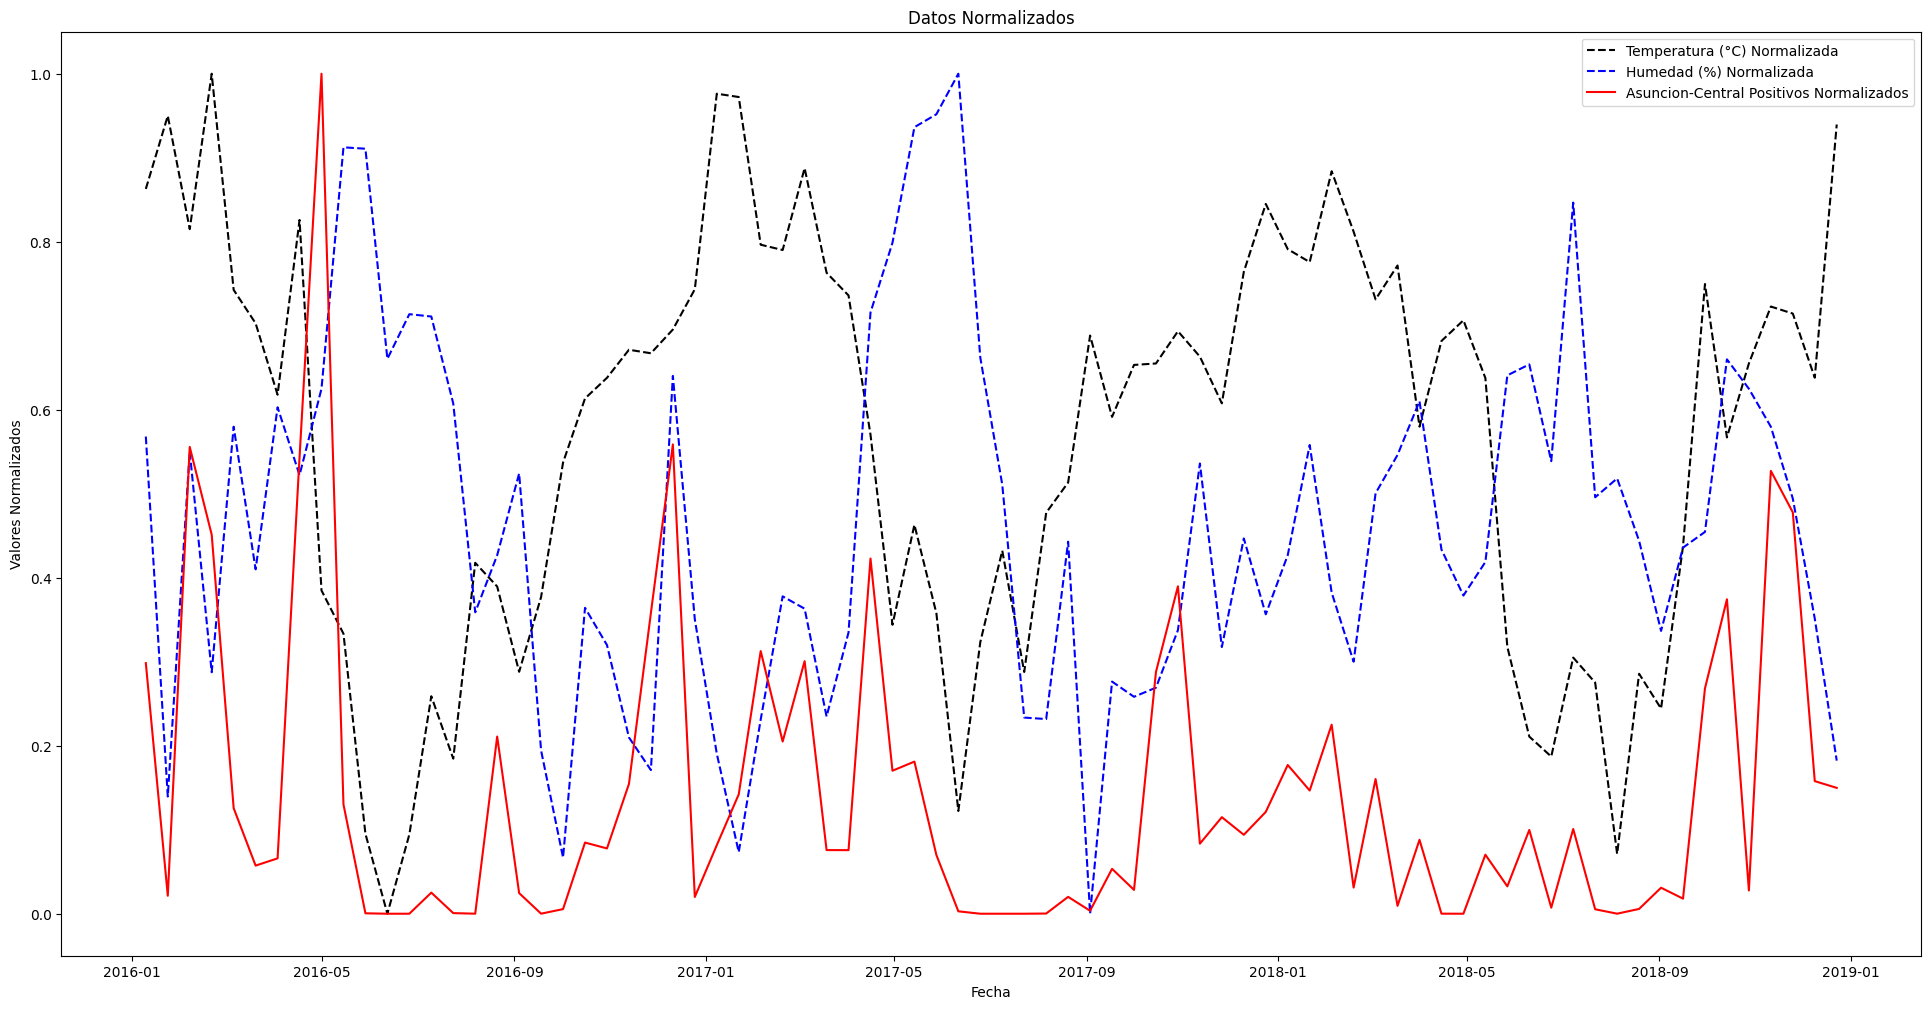

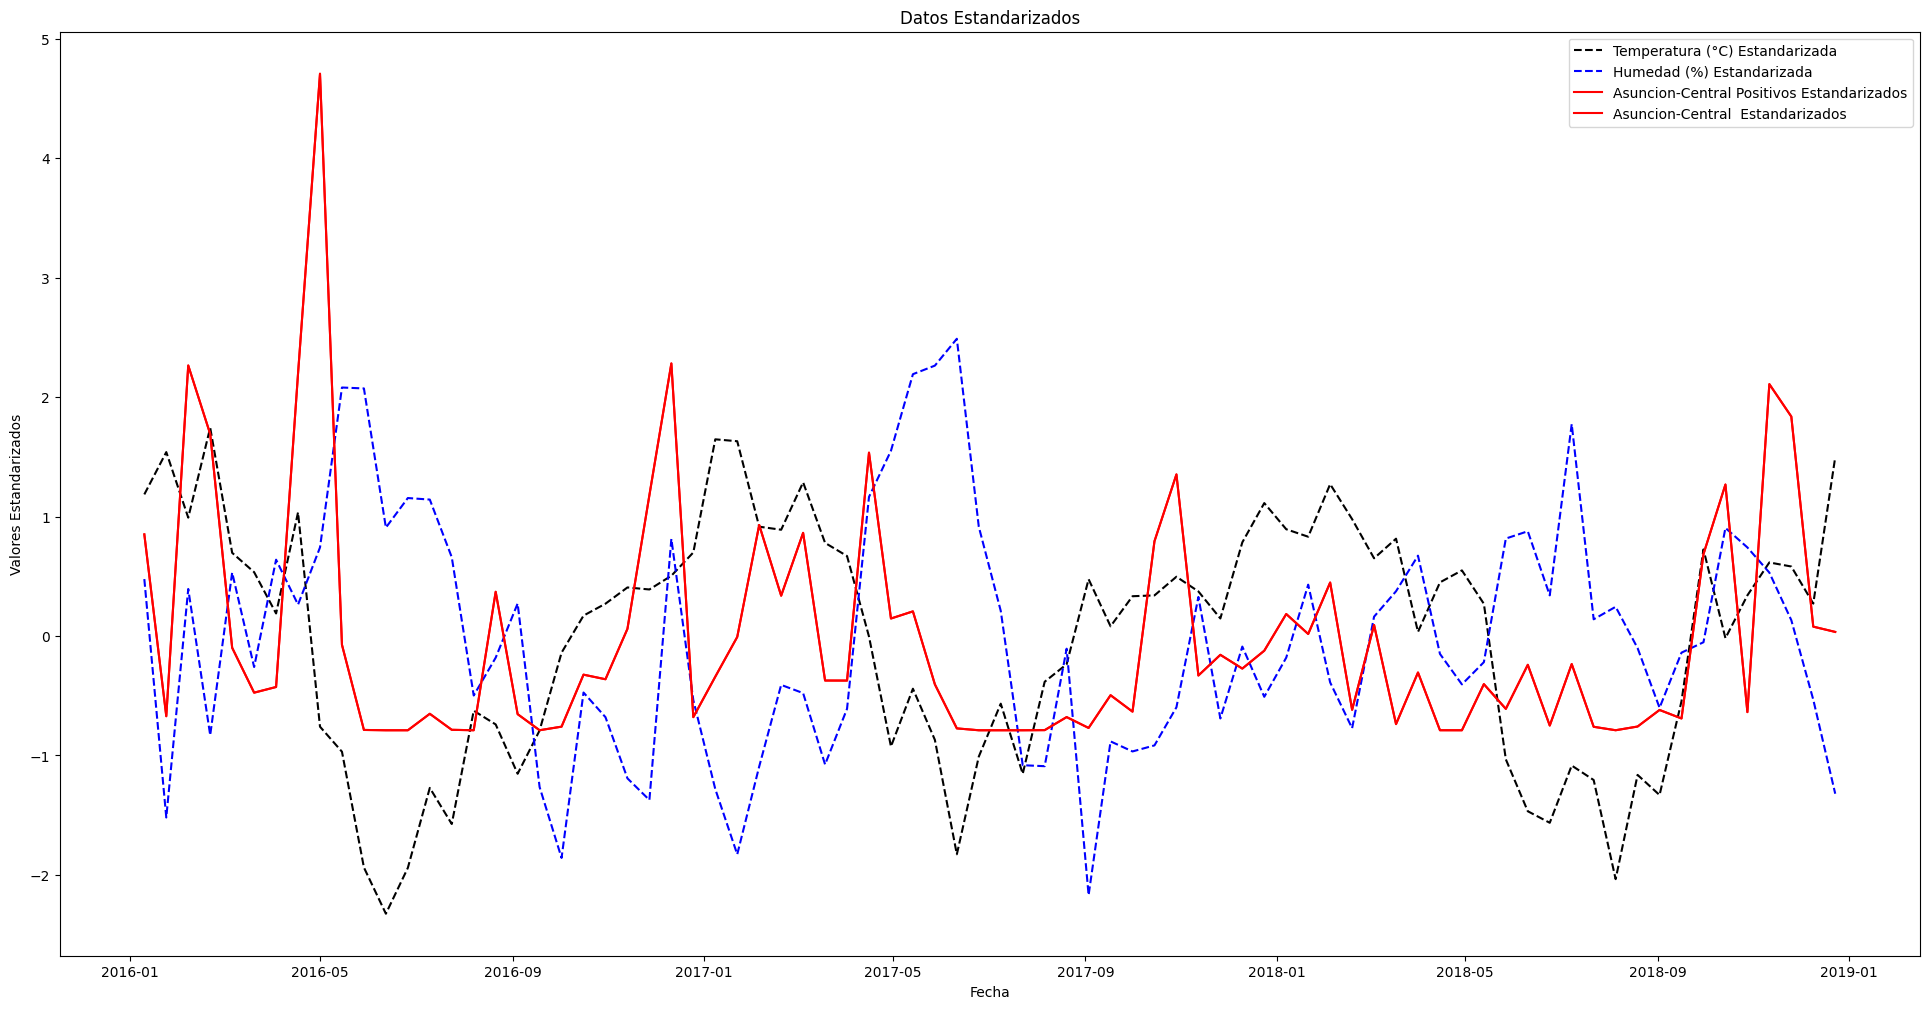

In [ ]:
# Remuestreo de los datos
df_temp_humedad_resampled = df_temp_humedad.resample('2W').mean()

df_rayos_resampled = {}
for lugar in ['Asuncion', 'Central','Concepcion','Neembucu']:
    # Suponiendo que los archivos CSV ya tienen las columnas 'Positivo' y 'Negativo'
    df_rayos_resampled[lugar] = df_rayos[lugar].resample('2W').sum()

    # Renombrar las columnas para incluir el nombre de la ciudad como prefijo
    df_rayos_resampled[lugar] =tratar_valores_atipicos(df_rayos_resampled[lugar], ['Positivo', 'Negativo'])
    df_rayos_resampled[lugar].columns = [f'{lugar}_{col}' for col in df_rayos_resampled[lugar].columns]
print(df_rayos_resampled)

df_temp_humedad_resampled = tratar_valores_atipicos(df_temp_humedad_resampled, ['Temperatura', 'Humedad'])


# Combinar los datos de temperatura, humedad con los datos de incidencia de rayos
df_combinado = pd.concat([df_temp_humedad_resampled, *df_rayos_resampled.values()], axis=1)
for lugar in ['Asuncion','Central','Neembucu','Concepcion']:
    df_combinado[lugar] = 0.5*(df_combinado[f'{lugar}_Negativo'] + df_combinado[f'{lugar}_Positivo']) + 0.5*(df_combinado[f'{lugar}_Snet_Negativo']+df_combinado[f'{lugar}_Snet_Positivo'])
df_combinado['Asuncion-Central'] = df_combinado['Central'] + df_combinado['Asuncion']


df_combinado=df_combinado[(df_combinado.index >= '2016') & (df_combinado.index <= '2019')]

# Normalizar los datos
scaler_min_max = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler_min_max.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)

# Estandarizar los datos
scaler_std = StandardScaler()
df_estandarizado = pd.DataFrame(scaler_std.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)

# Graficar los datos normalizados
plt.figure(figsize=(24, 12))
plt.plot(df_normalizado.index, df_normalizado['Temperatura'], label='Temperatura (°C) Normalizada',color='black', linestyle='--')
plt.plot(df_normalizado.index, df_normalizado['Humedad'], label='Humedad (%) Normalizada', color='blue', linestyle='--')
# plt.plot(df_normalizado.index, df_normalizado['Asuncion_Positivo'], label='Asuncion Positivos Normalizados', linestyle='--')
# plt.plot(df_normalizado.index, df_normalizado['Central_Positivo'], label='Central Positivos Normalizados', linestyle='--')


plt.plot(df_normalizado.index, df_normalizado['Asuncion-Central'], label='Asuncion-Central Positivos Normalizados', color='red')

plt.xlabel('Fecha')
plt.ylabel('Valores Normalizados')
plt.title('Datos Normalizados')
plt.legend()
plt.show()

# Graficar los datos estandarizados
plt.figure(figsize=(24, 12))
plt.plot(df_estandarizado.index, df_estandarizado['Temperatura'], label='Temperatura (°C) Estandarizada',color='black', linestyle='--')
plt.plot(df_estandarizado.index, df_estandarizado['Humedad'], label='Humedad (%) Estandarizada', color='blue', linestyle='--')
# plt.plot(df_estandarizado.index, df_estandarizado['Asuncion_Positivo'], label='Asuncion Positivos Estandarizados', linestyle='--')
# plt.plot(df_estandarizado.index, df_estandarizado['Central_Positivo'], label='Central Positivos Estandarizados', linestyle='--')

plt.plot(df_estandarizado.index, df_estandarizado['Asuncion-Central'], label='Asuncion-Central Positivos Estandarizados', color='red')

plt.plot(df_estandarizado.index, df_estandarizado['Asuncion-Central'], label='Asuncion-Central  Estandarizados', color='red')

plt.xlabel('Fecha')
plt.ylabel('Valores Estandarizados')
plt.title('Datos Estandarizados')
plt.legend()
plt.show()


In [ ]:
print(df_combinado[["Temperatura", "Humedad", "Asuncion-Central"]])

            Temperatura    Humedad  Asuncion-Central
2016-01-10    29.710751  67.284908       2946.154056
2016-01-24    31.381045  47.729252        211.250000
2016-02-07    28.793305  66.472699       5486.787709
2016-02-21    32.341942  54.480706       4455.756787
2016-03-06    27.404766  67.820507       1241.050846
...                 ...        ...               ...
2018-10-28    25.725369  69.880652        272.900000
2018-11-11    27.024843  67.816355       5205.820311
2018-11-25    26.864200  63.914008       4718.315989
2018-12-09    25.399671  57.392973       1558.532622
2018-12-23    31.182360  49.679231       1479.246487

[78 rows x 3 columns]


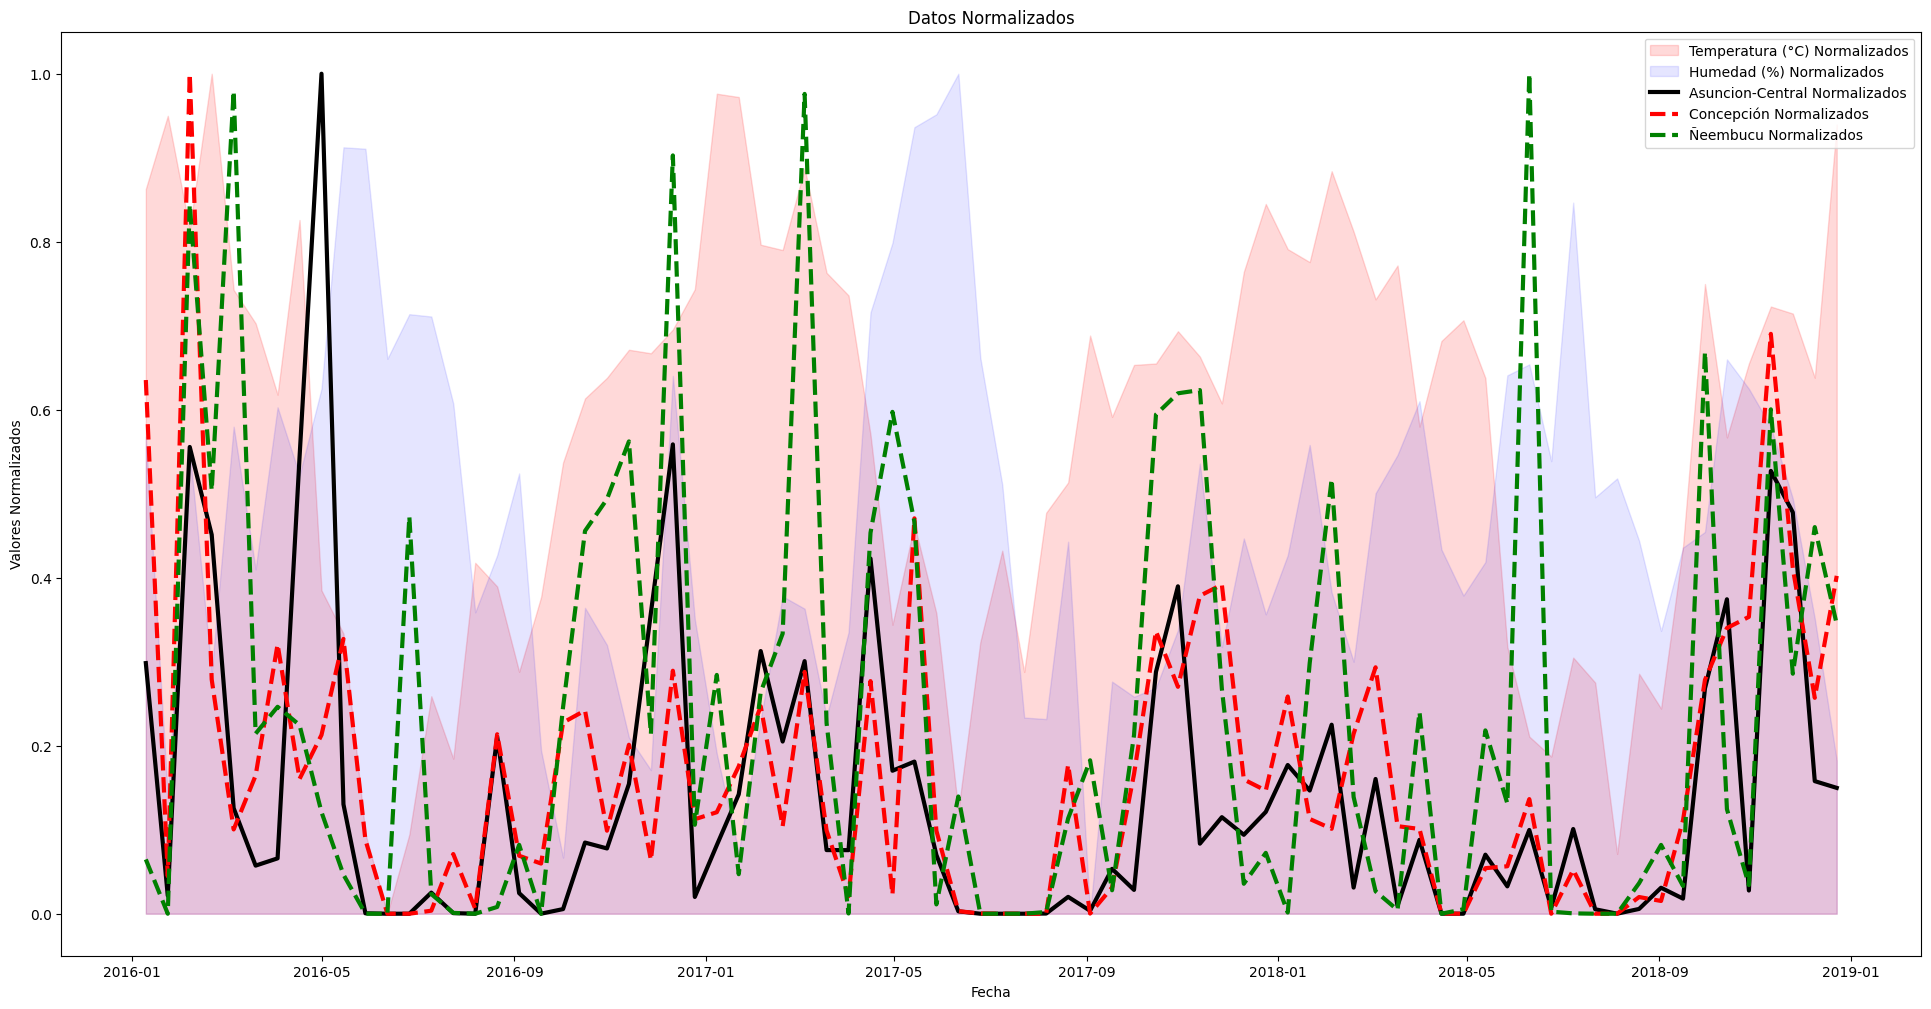

In [ ]:
# Graficar los datos estandarizados
plt.figure(figsize=(24, 12))
# Graficar la temperatura como un gráfico de área
plt.fill_between(df_normalizado.index, df_normalizado['Temperatura'], label='Temperatura (°C) Normalizados', color='red', alpha=0.15)

# Graficar la humedad como un gráfico de área
plt.fill_between(df_normalizado.index, df_normalizado['Humedad'], label='Humedad (%) Normalizados', color='blue', alpha=0.1)
# plt.plot(df_estandarizado.index, df_estandarizado['Asuncion_Positivo'], label='Asuncion Positivos Estandarizados', linestyle='--')
# plt.plot(df_estandarizado.index, df_estandarizado['Central_Positivo'], label='Central Positivos Estandarizados', linestyle='--')

# plt.plot(df_normalizado.index, df_normalizado['Asuncion-Central_Negativo'],
#          label='Asuncion-Central Negativo Normalizados',
#          color='red',
#          linestyle='--',
#          )
# plt.plot(df_normalizado.index, df_normalizado['Asuncion-Central_Positivo'],
#          label='Asuncion-Central Positivos Normalizados',
#          color='blue',linestyle='dotted',
#          )
plt.plot(df_normalizado.index, df_normalizado['Asuncion-Central'],
         label='Asuncion-Central Normalizados',
         color='black',linewidth=3,
         )
plt.plot(df_normalizado.index, df_normalizado['Concepcion'],
         label='Concepción Normalizados',
         color='red',linestyle='--',linewidth=3,
         )

plt.plot(df_normalizado.index, df_normalizado['Neembucu'],
         label='Ñeembucu Normalizados',
         color='green',linestyle='--',linewidth=3,
         )
plt.xlabel('Fecha')
plt.ylabel('Valores Normalizados')
plt.title('Datos Normalizados')
plt.legend()
plt.show()
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'



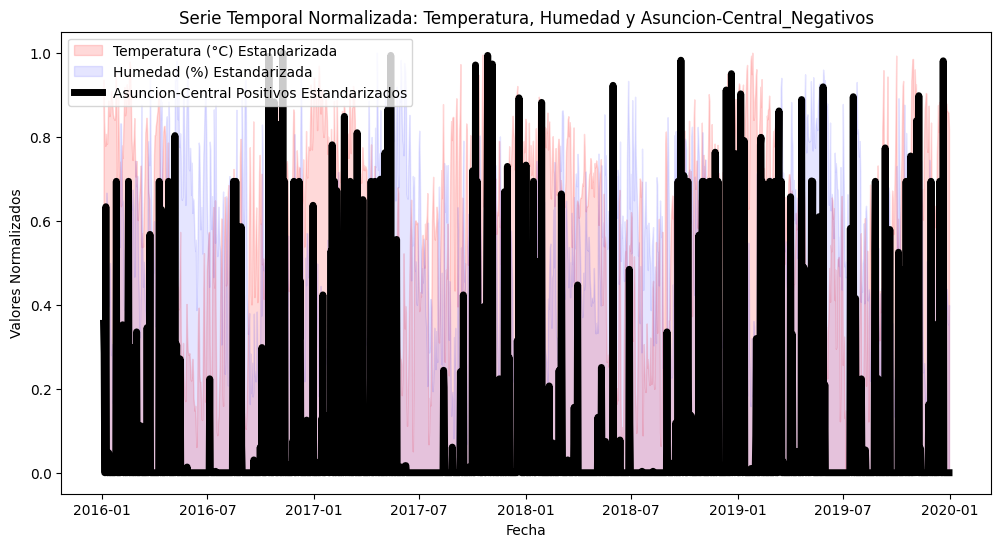

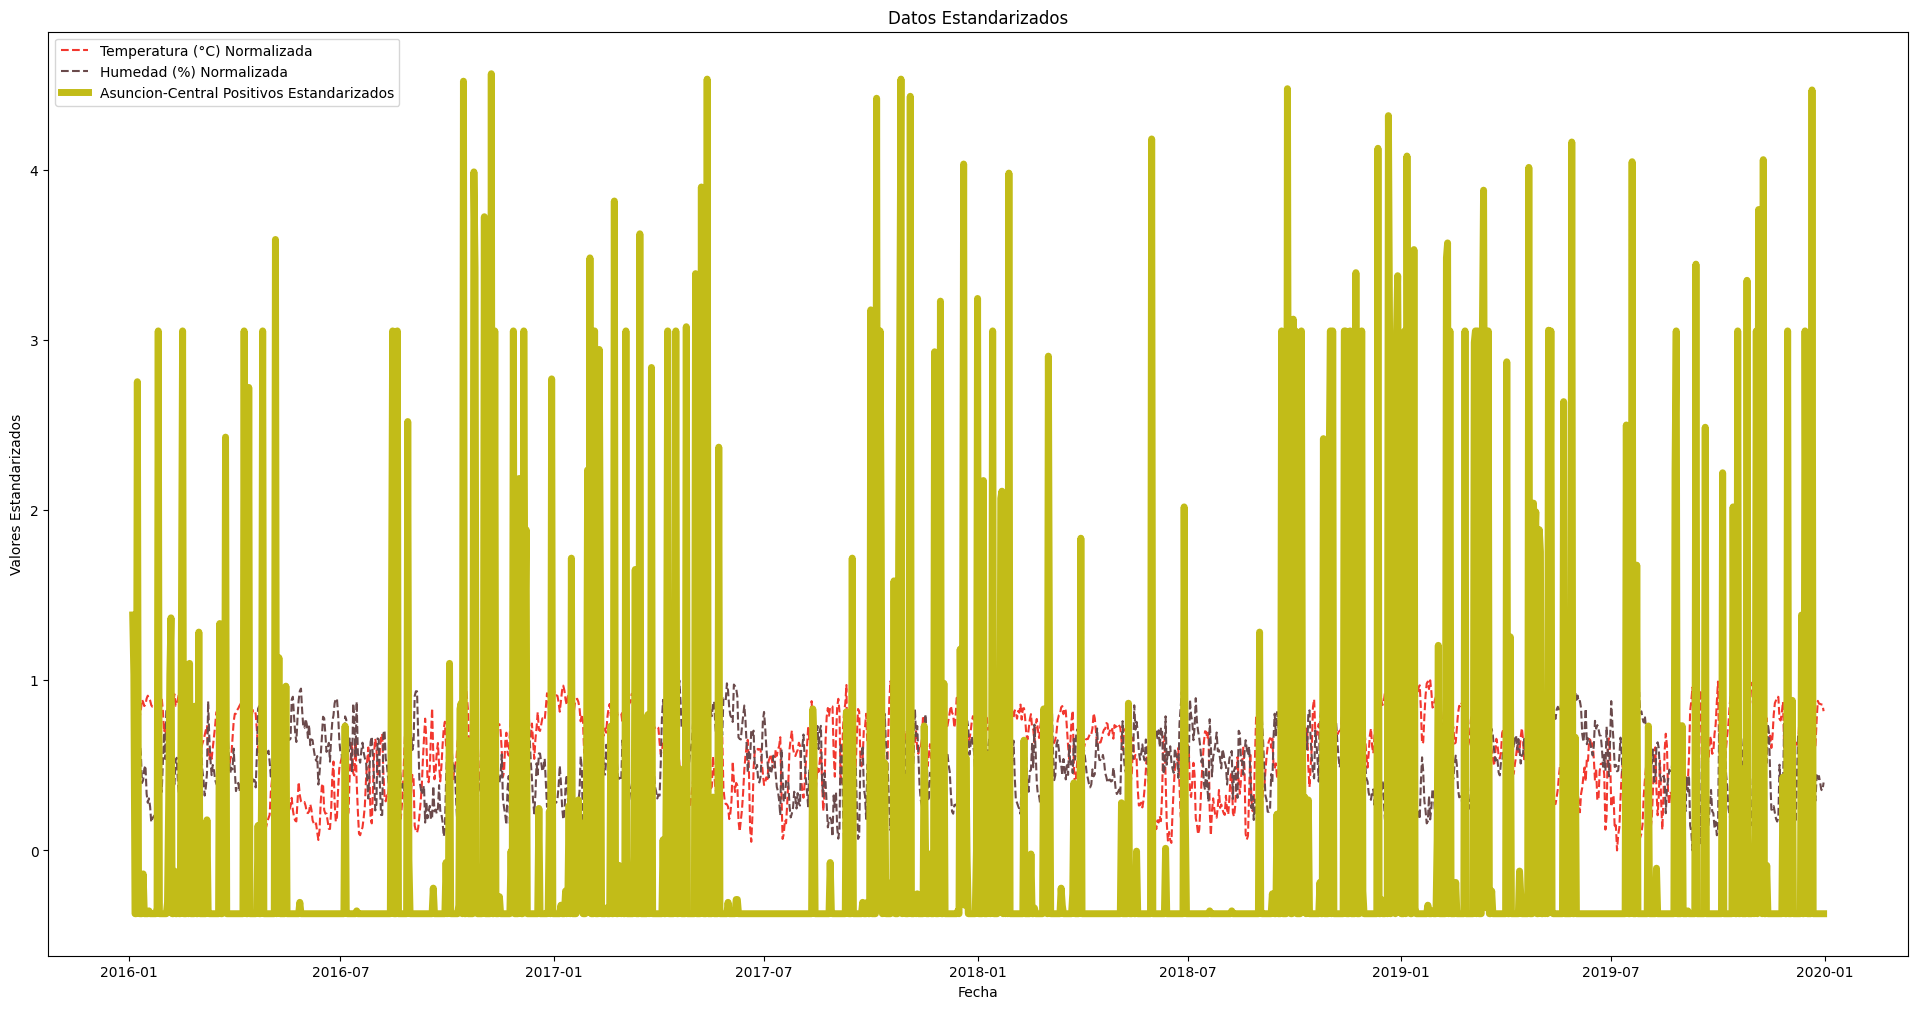

In [ ]:
# Asumiendo que df_temp_humedad_resampled y df_rayos_resampled ya están definidos y contienen datos remuestreados y tratados para valores atípicos.
# Remuestreo de los datos
df_temp_humedad_resampled = df_temp_humedad.resample('1D').mean()

df_rayos_resampled = {}
for lugar in ['Asuncion', 'Central','Concepcion','Neembucu']:
    # Suponiendo que los archivos CSV ya tienen las columnas 'Positivo' y 'Negativo'

    df_rayos_resampled[lugar] = df_rayos[lugar].resample('1D').sum()
    df_rayos_resampled[lugar] =tratar_valores_atipicos(df_rayos_resampled[lugar], ['Positivo', 'Negativo'])
    df_rayos_resampled[lugar].columns = [f'{lugar}_{col}' for col in df_rayos_resampled[lugar].columns]
df_temp_humedad_resampled = tratar_valores_atipicos(df_temp_humedad_resampled, ['Temperatura', 'Humedad'])

# Combinar los datos de temperatura, humedad con los datos de incidencia de rayos
df_combinado = pd.concat([df_temp_humedad_resampled, *df_rayos_resampled.values()], axis=1)
df_combinado['Asuncion-Central_Positivo'] = df_combinado['Central_Positivo'] + df_combinado['Asuncion_Positivo']
df_combinado['Asuncion-Central_Negativo'] = df_combinado['Central_Negativo'] + df_combinado['Asuncion_Negativo']
# print(df_combinado['Neembucu_Positivo'])

# Normalizar los datos
scaler_min_max = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler_min_max.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)
# Visualización de la serie temporal normalizada: Temperatura, Humedad y Asuncion-Central_Negativos
plt.figure(figsize=(12, 6))


# Graficar la temperatura como un gráfico de área
plt.fill_between(df_normalizado.index, df_normalizado['Temperatura'], label='Temperatura (°C) Estandarizada', color='red', alpha=0.15)

# Graficar la humedad como un gráfico de área
plt.fill_between(df_normalizado.index, df_normalizado['Humedad'], label='Humedad (%) Estandarizada', color='blue', alpha=0.1)

# plt.scatter(df_normalizado.index, df_normalizado['Temperatura'], color='red')
# plt.scatter(df_normalizado.index, df_normalizado['Humedad'], color='blue')
# # Línea para los rayos
plt.plot(df_normalizado.index, df_normalizado['Asuncion-Central_Positivo'], label='Asuncion-Central Positivos Estandarizados', color='black',alpha=1, linewidth=5)


# plt.plot(df_normalizado.index, df_normalizado['Temperatura'], label='Temperatura (°C) Normalizada', color='#F2372E', linestyle='--')
# plt.plot(df_normalizado.index, df_normalizado['Humedad'], label='Humedad (%) Normalizada', color='#6A4A4B' , linestyle='--')
# plt.plot(df_normalizado.index, df_normalizado['Asuncion-Central_Positivo'], label='Asuncion-Central Negativos Normalizados',  color='#C2BC18',linewidth=5)
plt.xlabel('Fecha')
plt.ylabel('Valores Normalizados')
plt.title('Serie Temporal Normalizada: Temperatura, Humedad y Asuncion-Central_Negativos')
plt.legend()
plt.show()


# Estandarizar los datos
scaler_std = StandardScaler()
df_estandarizado = pd.DataFrame(scaler_std.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)

# Graficar los datos estandarizados
plt.figure(figsize=(24, 12))
plt.plot(df_normalizado.index, df_normalizado['Temperatura'], label='Temperatura (°C) Normalizada', color='#F2372E', linestyle='--')
plt.plot(df_normalizado.index, df_normalizado['Humedad'], label='Humedad (%) Normalizada',
         color='#6A4A4B' , linestyle='--')
plt.plot(df_estandarizado.index, df_estandarizado['Asuncion-Central_Positivo'],
         label='Asuncion-Central Positivos Estandarizados', color='#C2BC18',linewidth=5)
# plt.plot(df_estandarizado.index, df_estandarizado['Concepcion_Positivo'], label='Concepcion Positivos Estandarizados', linestyle='--')


plt.xlabel('Fecha')
plt.ylabel('Valores Estandarizados')
plt.title('Datos Estandarizados')
plt.legend()
plt.show()


In [ ]:
df_combinado

Temperatura    Humedad  Asuncion_Positivo  Asuncion_Negativo  \
2016-01-04    33.347442  53.838963               98.0         173.003382   
2016-01-05    30.613762  64.865987               68.0          99.000000   
2016-01-06    29.550631  65.461286                0.0           0.000000   
2016-01-07    29.018269  63.351674                0.0           0.000000   
2016-01-08    29.799738  67.631599               36.0          91.000000   
...                 ...        ...                ...                ...   
2019-12-27    31.350951  56.503818                0.0           0.000000   
2019-12-28    31.301829  53.589140                0.0           0.000000   
2019-12-29    31.218181  50.385805                0.0           0.000000   
2019-12-30    31.191410  50.075682                0.0           0.000000   
2019-12-31    30.126668  53.594650                0.0           0.000000   

            Asuncion_Snet_Negativo  Asuncion_Snet_Positivo  Central_Positivo  \
2016-01-04                   748.5                   463.1               7.0   
2016-01-05                   432.0                   105.8              16.0   
2016-01-06                     0.0                     0.0               0.0   
2016-01-07                     0.0                     0.0               0.0   
2016-01-08                   239.7                   167.6             151.0   
...                            ...                     ...               ...   
2019-12-27                     0.0                     0.0               0.0   
2019-12-28                     0.0                     0.0               0.0   
2019-12-29                     0.0                     0.0               0.0   
2019-12-30                     0.0                     0.0               0.0   
2019-12-31                     0.0                     0.0               0.0   

            Central_Negativo  Central_Snet_Negativo  Central_Snet_Positivo  \
2016-01-04          10.00000                   91.9                   62.9   
2016-01-05          45.00000                  270.9                   63.0   
2016-01-06           0.00000                    0.0                    0.0   
2016-01-07           0.00000                    0.0                    0.0   
2016-01-08         176.60473                 1480.6                  712.3   
...                      ...                    ...                    ...   
2019-12-27           0.00000                    0.0                    0.0   
2019-12-28           0.00000                    0.0                    0.0   
2019-12-29           0.00000                    0.0                    0.0   
2019-12-30           0.00000                    0.0                    0.0   
2019-12-31           0.00000                    0.0                    0.0   

            Concepcion_Positivo  Concepcion_Negativo  \
2016-01-04            94.578146           162.242334   
2016-01-05           109.000000           158.000000   
2016-01-06             3.000000             0.000000   
2016-01-07             0.000000             0.000000   
2016-01-08           156.023556           107.379903   
...                         ...                  ...   
2019-12-27             0.000000             0.000000   
2019-12-28             0.000000             0.000000   
2019-12-29             0.000000             0.000000   
2019-12-30             0.000000             0.000000   
2019-12-31             0.000000             0.000000   

            Concepcion_Snet_Negativo  Concepcion_Snet_Positivo  \
2016-01-04                     479.2                     192.3   
2016-01-05                     250.3                     112.1   
2016-01-06                       0.0                       0.0   
2016-01-07                       0.0                       0.0   
2016-01-08                     371.1                      90.7   
...                              ...                       ...   
2019-12-27                       0.0                       0.0   


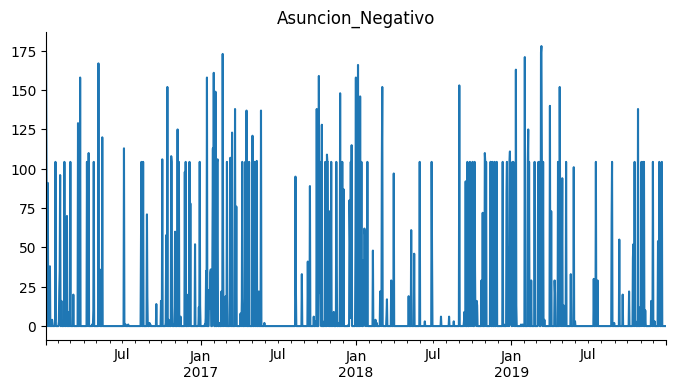

In [ ]:
# @title Asuncion_Negativo

df_combinado['Asuncion_Negativo'].plot(kind='line', figsize=(8, 4), title='Asuncion_Negativo')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df_combinado[(df_combinado.index>= '2016') & (df_combinado.index <= '2018')]

Temperatura    Humedad  Asuncion_Positivo  Asuncion_Negativo  \
2016-01-04    33.347442  53.838963          98.000000         173.003382   
2016-01-05    30.613762  64.865987          68.000000          99.000000   
2016-01-06    29.550631  65.461286           0.000000           0.000000   
2016-01-07    29.018269  63.351674           0.000000           0.000000   
2016-01-08    29.799738  67.631599          36.000000          91.000000   
...                 ...        ...                ...                ...   
2017-12-28    29.325542  71.220610           0.000000           0.000000   
2017-12-29    28.592962  66.956274           0.000000           0.000000   
2017-12-30    29.396800  56.672001           0.000000           0.000000   
2017-12-31    30.788300  52.192831          21.000000          50.000000   
2018-01-01    30.577202  57.970915         123.265616         158.005073   

            Asuncion_Snet_Negativo  Asuncion_Snet_Positivo  Central_Positivo  \
2016-01-04                   748.5                   463.1               7.0   
2016-01-05                   432.0                   105.8              16.0   
2016-01-06                     0.0                     0.0               0.0   
2016-01-07                     0.0                     0.0               0.0   
2016-01-08                   239.7                   167.6             151.0   
...                            ...                     ...               ...   
2017-12-28                     0.0                     0.0               0.0   
2017-12-29                     0.0                     0.0               0.0   
2017-12-30                     0.0                     0.0               0.0   
2017-12-31                    15.5                    31.1               1.0   
2018-01-01                  1173.4                   912.4              93.0   

            Central_Negativo  Central_Snet_Negativo  Central_Snet_Positivo  \
2016-01-04         10.000000                   91.9                   62.9   
2016-01-05         45.000000                  270.9                   63.0   
2016-01-06          0.000000                    0.0                    0.0   
2016-01-07          0.000000                    0.0                    0.0   
2016-01-08        176.604730                 1480.6                  712.3   
...                      ...                    ...                    ...   
2017-12-28          0.000000                    0.0                    0.0   
2017-12-29          0.000000                    0.0                    0.0   
2017-12-30          0.000000                    0.0                    0.0   
2017-12-31          2.000000                    3.9                   18.3   
2018-01-01        198.802365                   76.1                  160.6   

            Concepcion_Positivo  Concepcion_Negativo  \
2016-01-04            94.578146           162.242334   
2016-01-05           109.000000           158.000000   
2016-01-06             3.000000             0.000000   
2016-01-07             0.000000             0.000000   
2016-01-08           156.023556           107.379903   
...                         ...                  ...   
2017-12-28            93.000000           179.121167   
2017-12-29             0.000000             0.000000   
2017-12-30             0.000000             0.000000   
2017-12-31             1.000000             4.000000   
2018-01-01            94.578146           107.379903   

            Concepcion_Snet_Negativo  Concepcion_Snet_Positivo  \
2016-01-04                     479.2                     192.3   
2016-01-05                     250.3                     112.1   
2016-01-06                       0.0                       0.0   
2016-01-07                       0.0                       0.0   
2016-01-08                     371.1                      90.7   
...                              ...                       ...   
2017-12-28                       0.0                       0.0   


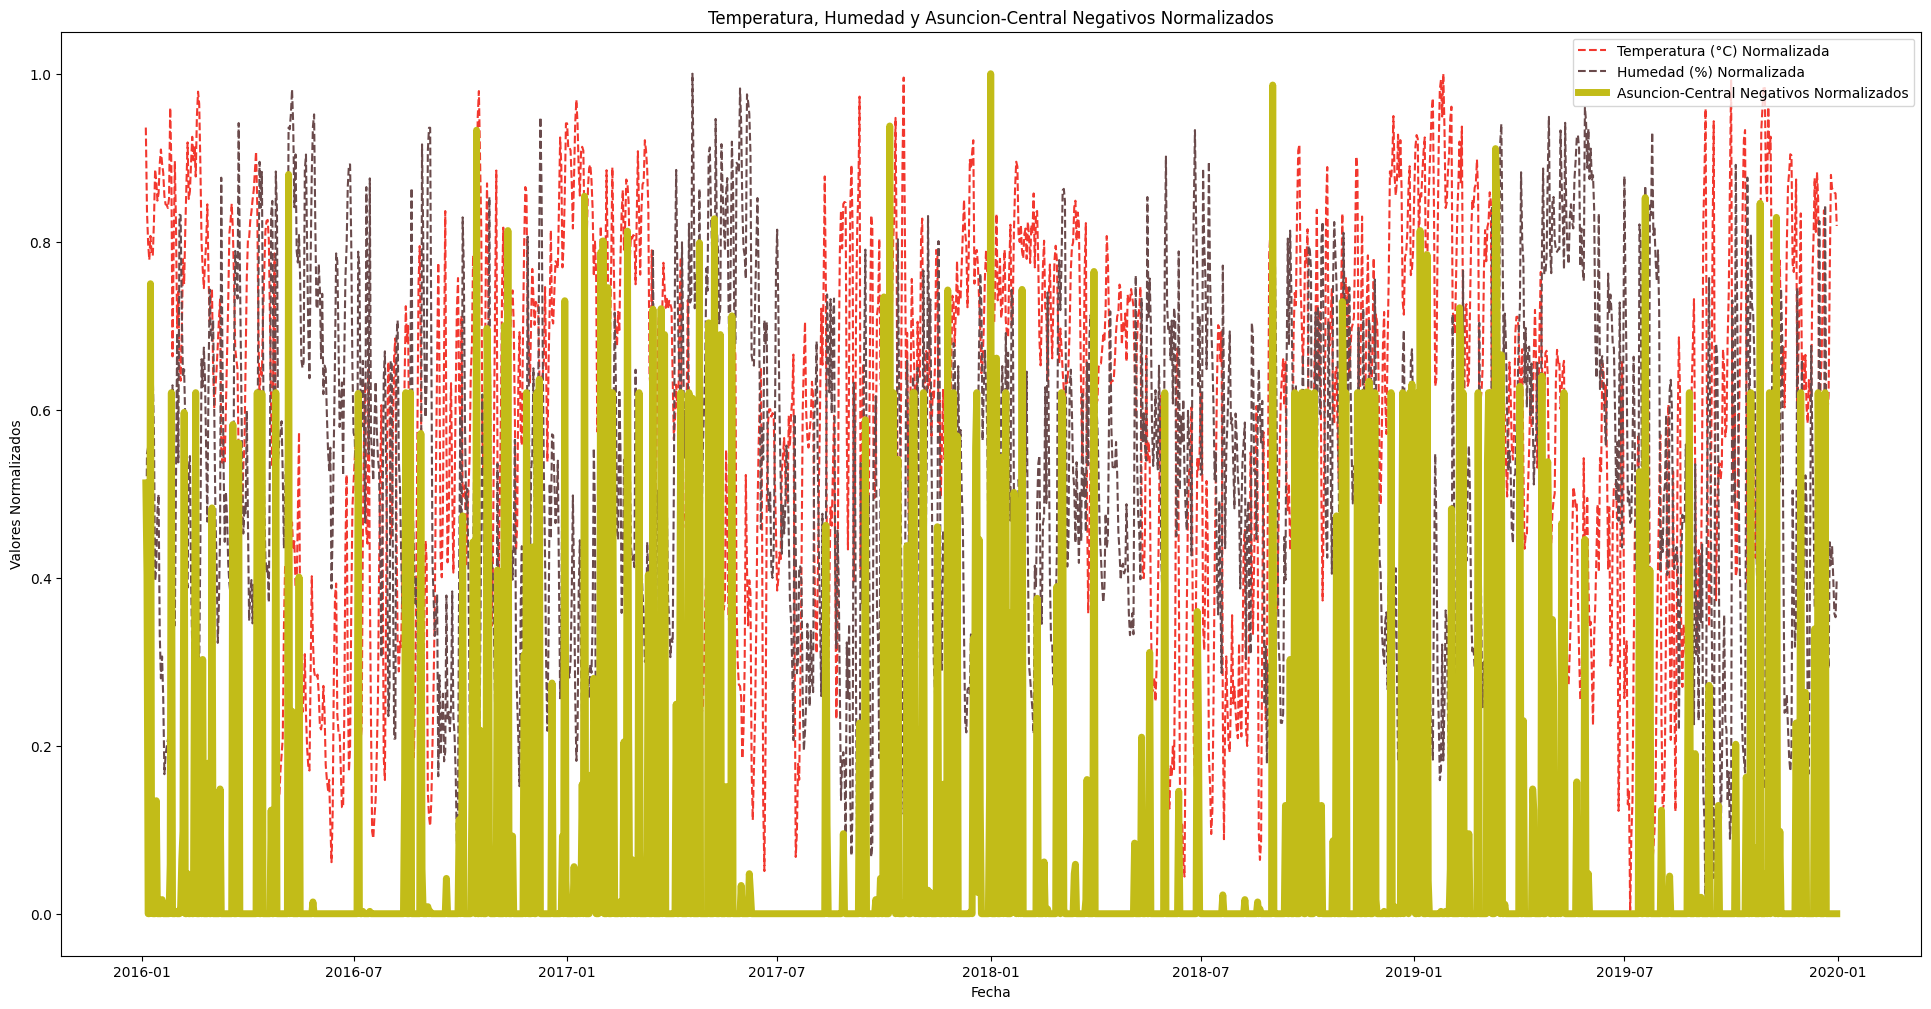

In [ ]:
# Graficar los datos normalizados - Serie Temporal 1
plt.figure(figsize=(24, 12))
plt.plot(df_normalizado.index, df_normalizado['Temperatura'],
         label='Temperatura (°C) Normalizada',
         color='#F2372E',
         linestyle='--',
         )
plt.plot(df_normalizado.index,
         df_normalizado['Humedad'],
         label='Humedad (%) Normalizada',
         color='#6A4A4B',
         linestyle='--',
         )
plt.plot(df_normalizado.index,
         df_normalizado['Asuncion-Central_Negativo'],
         label='Asuncion-Central Negativos Normalizados',
         color='#C2BC18',
         linewidth=5,
         )
plt.xlabel('Fecha')
plt.ylabel('Valores Normalizados')
plt.title('Temperatura, Humedad y Asuncion-Central Negativos Normalizados')
plt.legend()
plt.show()


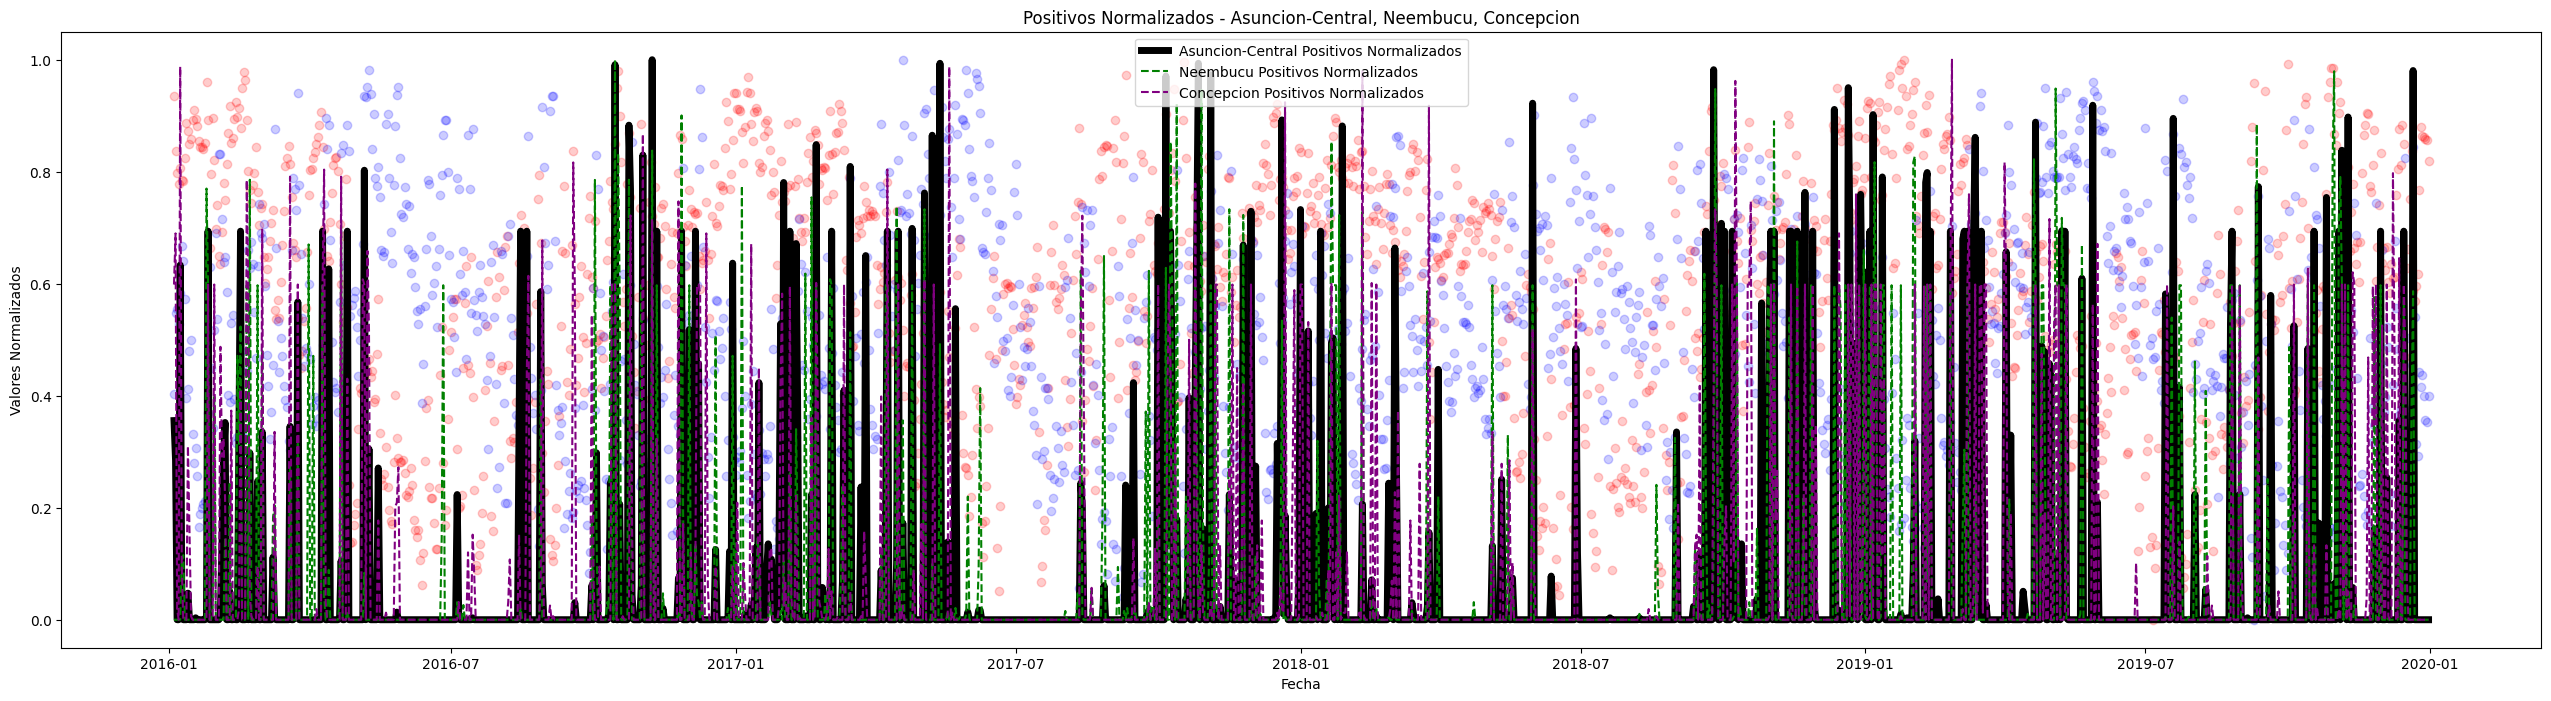

In [ ]:
# Graficar los datos normalizados - Serie Temporal 2
plt.figure(figsize=(32, 8))

plt.scatter(df_normalizado.index, df_normalizado['Temperatura'], color='red',alpha=0.2)
plt.scatter(df_normalizado.index, df_normalizado['Humedad'], color='blue',alpha=0.2)

plt.plot(df_normalizado.index,
         df_normalizado['Asuncion-Central_Positivo'],
         label='Asuncion-Central Positivos Normalizados',
         color='black',
         linewidth=5,
         )

plt.plot(df_normalizado.index,
         df_normalizado['Neembucu_Positivo'],
         label='Neembucu Positivos Normalizados',
         color='green',
         linestyle='--',

         )
plt.plot(df_normalizado.index,
         df_normalizado['Concepcion_Positivo'],
         label='Concepcion Positivos Normalizados',
         color='purple',
         linestyle='--',

         )
plt.xlabel('Fecha')
plt.grid='True'
plt.ylabel('Valores Normalizados')
plt.title('Positivos Normalizados - Asuncion-Central, Neembucu, Concepcion')
plt.legend()
plt.show()

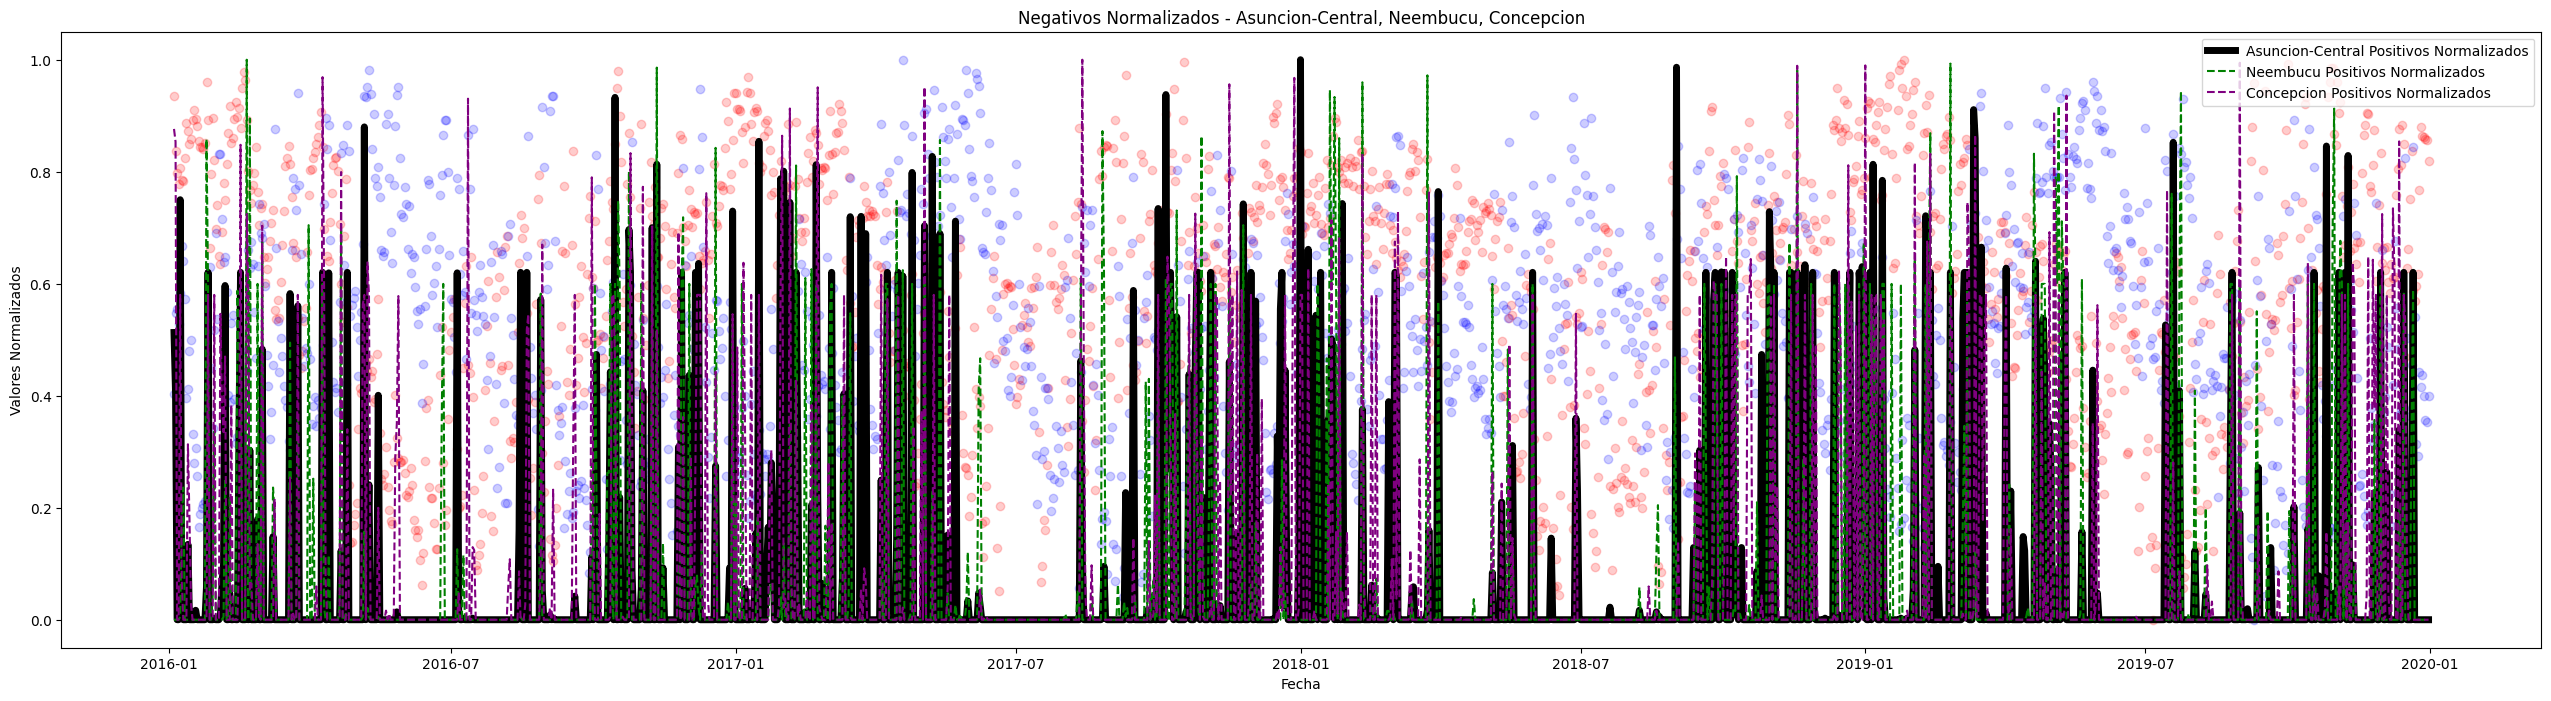

In [ ]:
# Graficar los datos normalizados - Serie Temporal 2
plt.figure(figsize=(32, 8))

plt.scatter(df_normalizado.index, df_normalizado['Temperatura'], color='red',alpha=0.2)
plt.scatter(df_normalizado.index, df_normalizado['Humedad'], color='blue',alpha=0.2)


plt.plot(df_normalizado.index,
         df_normalizado['Asuncion-Central_Negativo'],
         label='Asuncion-Central Positivos Normalizados',
         color='black',
         linewidth=5,
         )

plt.plot(df_normalizado.index,
         df_normalizado['Neembucu_Negativo'],
         label='Neembucu Positivos Normalizados',
         color='green',
         linestyle='--',

         )
plt.plot(df_normalizado.index,
         df_normalizado['Concepcion_Negativo'],
         label='Concepcion Positivos Normalizados',
         color='purple',
         linestyle='--',

         )
plt.xlabel('Fecha')
plt.grid='True'
plt.ylabel('Valores Normalizados')
plt.title('Negativos Normalizados - Asuncion-Central, Neembucu, Concepcion')
plt.legend()
plt.show()

# **Serie Temporal 2**

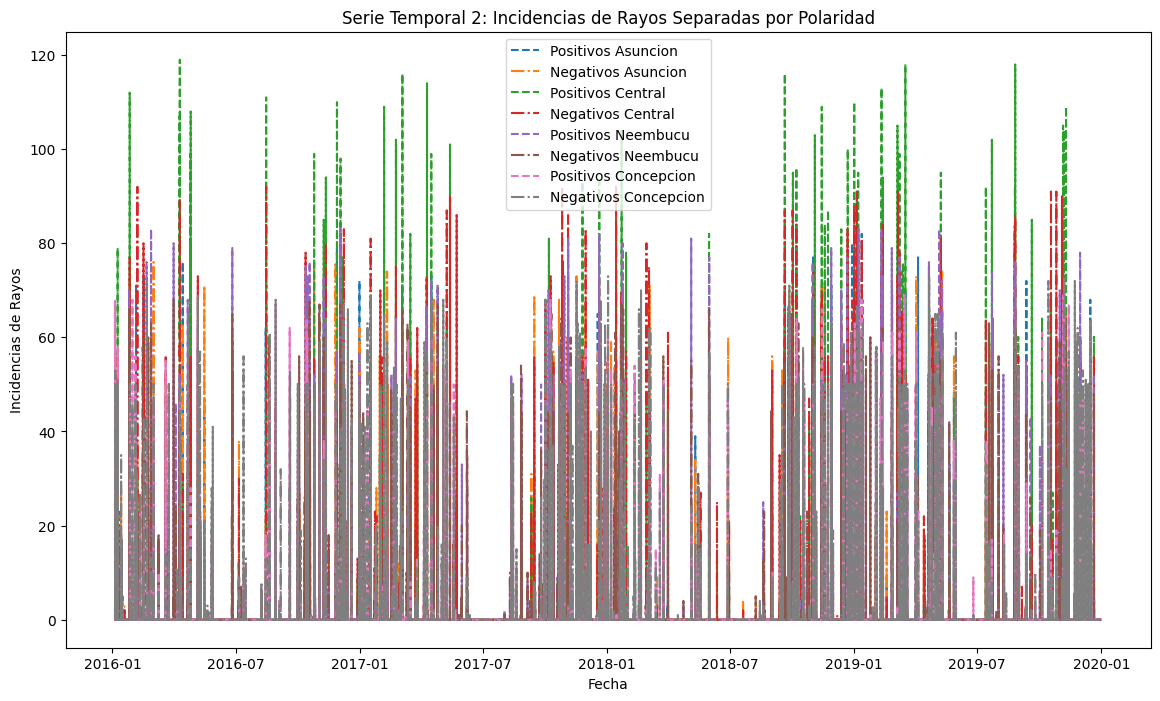

In [ ]:
plt.figure(figsize=(14, 8))
for lugar in ['Asuncion', 'Central', 'Neembucu', 'Concepcion']:
    plt.plot(df_rayos[lugar].index, df_rayos[lugar]['Positivo'], label=f'Positivos {lugar}', linestyle='--')
    plt.plot(df_rayos[lugar].index, df_rayos[lugar]['Negativo'], label=f'Negativos {lugar}', linestyle='-.')
plt.xlabel('Fecha')
plt.ylabel('Incidencias de Rayos')
plt.title('Serie Temporal 2: Incidencias de Rayos Separadas por Polaridad')
plt.legend()
plt.show()

# **Serie Temporal 3**

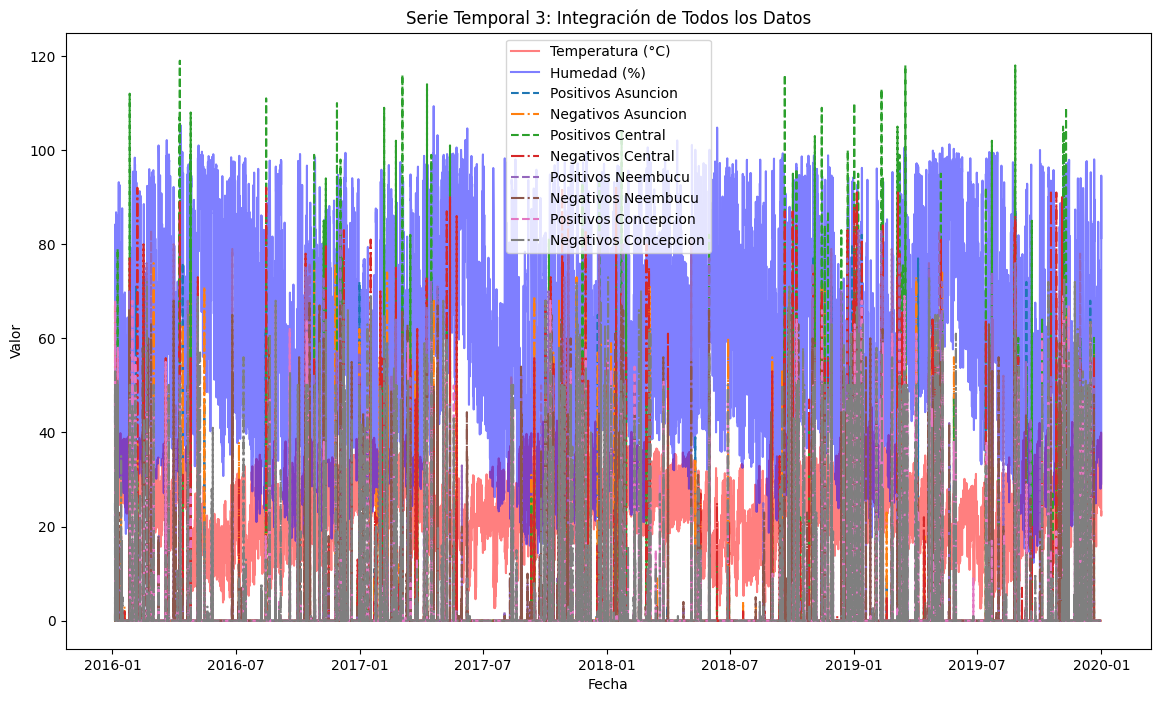

In [ ]:
plt.figure(figsize=(14, 8))
# Temperatura y Humedad
plt.plot(df_temp_humedad.index, df_temp_humedad['Temperatura'], label='Temperatura (°C)', color='red', alpha=0.5)
plt.plot(df_temp_humedad.index, df_temp_humedad['Humedad'], label='Humedad (%)', color='blue', alpha=0.5)

# Incidencias de Rayos para todas las localidades
for lugar in ['Asuncion', 'Central', 'Neembucu', 'Concepcion']:
    plt.plot(df_rayos[lugar].index, df_rayos[lugar]['Positivo'], label=f'Positivos {lugar}', linestyle='--')
    plt.plot(df_rayos[lugar].index, df_rayos[lugar]['Negativo'], label=f'Negativos {lugar}', linestyle='-.')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie Temporal 3: Integración de Todos los Datos')
plt.legend()
plt.show()

# **Training set**

In [ ]:
# Calcular métricas de rendimiento, como RMSE

# rmse = sqrt(mean_squared_error(y_test_inv, pred_inv))
# print('RMSE:', rmse)

In [ ]:
# Asumiendo que df_temp_humedad_resampled y df_rayos_resampled ya están definidos y contienen datos remuestreados y tratados para valores atípicos.
# Remuestreo de los datos
df_temp_humedad_resampled = df_temp_humedad.resample('1D').mean()

df_rayos_resampled = {}

for lugar in ['Asuncion', 'Central','Concepcion','Neembucu']:
    # Suponiendo que los archivos CSV ya tienen las columnas 'Positivo' y 'Negativo'
    df_rayos_resampled[lugar] = round(df_rayos[lugar].resample('1D').sum()).round()    # Renombrar las columnas para incluir el nombre de la ciudad como prefijo
    df_rayos_resampled[lugar] =round(tratar_valores_atipicos(df_rayos_resampled[lugar], ['Positivo', 'Negativo']))
    df_rayos_resampled[lugar].columns = [f'{lugar}_{col}' for col in df_rayos_resampled[lugar].columns]
df_temp_humedad_resampled = tratar_valores_atipicos(df_temp_humedad_resampled, ['Temperatura', 'Humedad'])

df_combinado = pd.concat([df_temp_humedad_resampled, *df_rayos_resampled.values()], axis=1)
df_combinado= round(df_combinado)
df_combinado['Asuncion-Central_Positivo'] = df_combinado['Central_Positivo'] + df_combinado['Asuncion_Positivo']
df_combinado['Asuncion-Central_Negativo'] = df_combinado['Central_Negativo'] + df_combinado['Asuncion_Negativo']

# Estandarizar los datos
scaler_std = StandardScaler()
df_estandarizado = pd.DataFrame(scaler_std.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)


In [ ]:
print(df_combinado.describe())

       Temperatura      Humedad  Asuncion_Positivo  Asuncion_Negativo  \
count  1458.000000  1458.000000        1458.000000        1458.000000   
mean     24.163923    62.713992          10.427984          12.641975   
std       5.906491    15.382422          28.999526          33.794680   
min       8.000000    23.000000           0.000000           0.000000   
25%      20.000000    51.000000           0.000000           0.000000   
50%      25.000000    62.000000           0.000000           0.000000   
75%      29.000000    74.000000           0.000000           0.000000   
max      35.000000    99.000000         158.000000         178.000000   

       Asuncion_Snet_Negativo  Asuncion_Snet_Positivo  Central_Positivo  \
count             1458.000000             1458.000000       1458.000000   
mean                37.436214               19.317558         11.790123   
std                314.078350              104.718926         33.770734   
min                  0.000000             

In [ ]:
df_combinado_19_20 = df_combinado[df_combinado.index.year.isin([2018])]
df_combinado_19_20.to_csv('/content/drive/MyDrive/2.TPInteligenciaArtificial/Organizado/DF_Combinado_19_20/df_combinado.csv', index=False)

In [ ]:
print(df_combinado_19_20.dtypes)

Temperatura                  float64
Humedad                      float64
Asuncion_Positivo            float64
Asuncion_Negativo            float64
Asuncion_Snet_Negativo       float64
Asuncion_Snet_Positivo       float64
Central_Positivo             float64
Central_Negativo             float64
Central_Snet_Negativo        float64
Central_Snet_Positivo        float64
Concepcion_Positivo          float64
Concepcion_Negativo          float64
Concepcion_Snet_Negativo     float64
Concepcion_Snet_Positivo     float64
Neembucu_Positivo            float64
Neembucu_Negativo            float64
Neembucu_Snet_Negativo       float64
Neembucu_Snet_Positivo       float64
Asuncion-Central_Positivo    float64
Asuncion-Central_Negativo    float64
dtype: object


# **Utilizando una arquitectura LSTM**

**Preparando los datos**

In [ ]:
# Remuestreo de los datos
df_temp_humedad_resampled = df_temp_humedad.resample('1D').mean()
df_temp_humedad_resampled = df_temp_humedad_resampled['2016':'2019']
df_rayos_resampled = {}
for lugar in ['Asuncion', 'Central','Concepcion','Neembucu']:
    # Suponiendo que los archivos CSV ya tienen las columnas 'Positivo' y 'Negativo'
    df_rayos_resampled[lugar] = df_rayos[lugar].resample('1D').sum()

    df_rayos_resampled[lugar] =tratar_valores_atipicos(df_rayos_resampled[lugar], ['Positivo', 'Negativo','Snet_Positivo', 'Snet_Negativo'])

    df_rayos_resampled[lugar].columns = [f'{lugar}_{col}' for col in df_rayos_resampled[lugar].columns]
print(df_rayos_resampled)

df_combinado = pd.DataFrame()

df_temp_humedad_resampled = tratar_valores_atipicos(df_temp_humedad_resampled, ['Temperatura', 'Humedad'])



for lugar in ['Concepcion','Asuncion','Central','Neembucu']:
  df_combinado[lugar] = df_rayos_resampled[lugar][[ f'{lugar}_Positivo', f'{lugar}_Negativo', f'{lugar}_Snet_Positivo', f'{lugar}_Snet_Negativo']].sum(axis=1).fillna(0)


df_combinado["Asuncion_Central"] = df_combinado[["Asuncion", "Central"]].max(axis=1)

df_combinado['Temperatura']=df_temp_humedad_resampled['Temperatura']
df_combinado['Humedad'] = df_temp_humedad_resampled['Humedad']

df_combinado=df_combinado[df_combinado.index <= '2019']

# Normalizar los datos
scaler_min_max = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler_min_max.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)

# Estandarizar los datos
scaler_std = StandardScaler()
df_estandarizado = pd.DataFrame(scaler_std.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)


{'Asuncion':             Asuncion_Positivo  Asuncion_Negativo  Asuncion_Snet_Negativo  \
timestamp                                                                  
2016-01-04               98.0         173.003382              175.465273   
2016-01-05               68.0          99.000000              432.000000   
2016-01-06                0.0           0.000000                0.000000   
2016-01-07                0.0           0.000000                0.000000   
2016-01-08               36.0          91.000000              239.700000   
...                       ...                ...                     ...   
2019-12-27                0.0           0.000000                0.000000   
2019-12-28                0.0           0.000000                0.000000   
2019-12-29                0.0           0.000000                0.000000   
2019-12-30                0.0           0.000000                0.000000   
2019-12-31                0.0           0.000000                0.000000   

**Crear features and targets variables**

In [ ]:
# Feature selection and target variable definition
features = df_combinado.drop(columns=['Asuncion_Central'],axis=1)
target = df_combinado['Asuncion_Central']

# Data scaling
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Create time series sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(features_scaled, n_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Modelo 1**

Epoch 1/100
28/28 [==============================] - 6s 48ms/step - loss: 0.0885 - val_loss: 0.0384
Epoch 2/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0328 - val_loss: 0.0351
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0314 - val_loss: 0.0336
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0306 - val_loss: 0.0331
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0298 - val_loss: 0.0320
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0295 - val_loss: 0.0315
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0295 - val_loss: 0.0318
Epoch 8/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0289 - val_loss: 0.0299
Epoch 9/100
28/28 [==============================] - 1s 27ms/step - loss: 0.0280 - val_loss: 0.0313
Epoch 10/100
28/28 [==============================] - 1s 31ms/step - loss: 0.0292 - val_loss: 0.0288

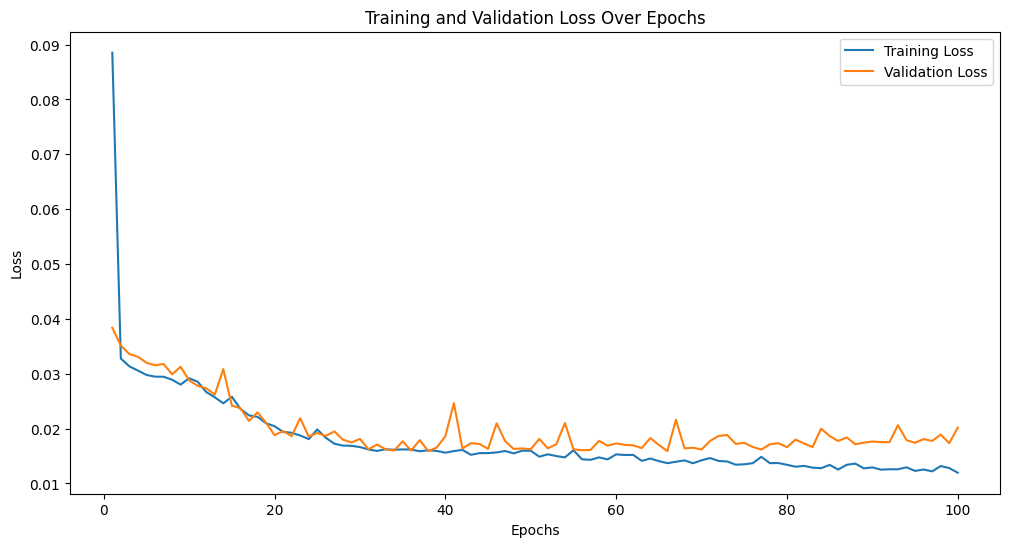

7/7 [==============================] - 1s 5ms/step


In [ ]:
# Define and build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, features_scaled.shape[1])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))


RMSE: 130.52
MAE: 102.61


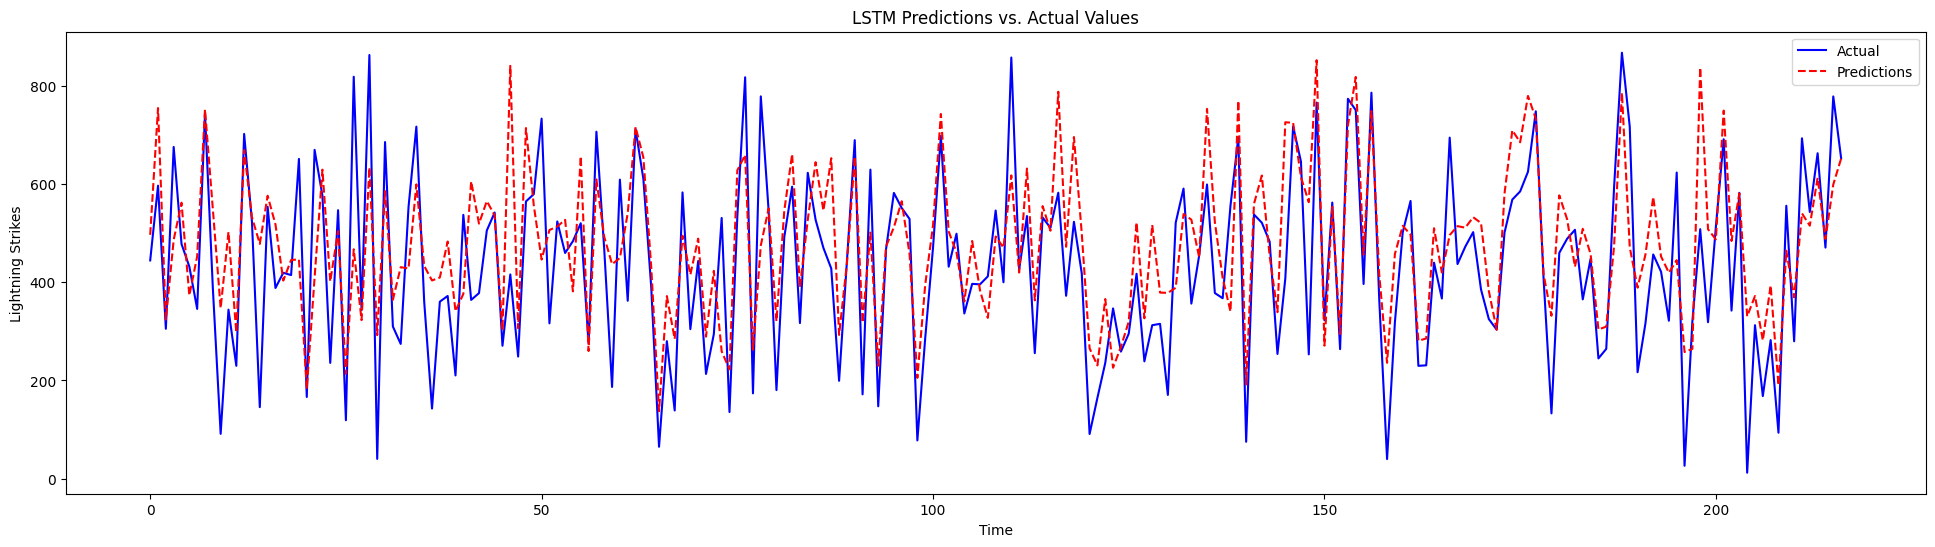

In [ ]:
# 1. Evaluate model performance
rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)  # RMSE
mae = mean_absolute_error(y_test_inv, y_pred_inv)  # MAE
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 2. Visualize predictions vs actual values
plt.figure(figsize=(24, 6))
plt.plot(y_test_inv[:400], label='Actual', color='blue')
plt.plot(y_pred_inv[:300], label='Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs. Actual Values")
plt.xlabel('Time')
plt.ylabel('Lightning Strikes')
plt.legend()
plt.show()

# **Modelo 2**

In [ ]:
#Adding more LSTM layers with different units
model_2 = Sequential()
model_2.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, features_scaled.shape[1])))
model_2.add(LSTM(64, activation='relu', return_sequences=True))  # Additional LSTM layer
model_2.add(LSTM(32))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mse')

Epoch 1/100
28/28 [==============================] - 7s 74ms/step - loss: 0.0897 - val_loss: 0.0408
Epoch 2/100
28/28 [==============================] - 1s 44ms/step - loss: 0.0369 - val_loss: 0.0373
Epoch 3/100
28/28 [==============================] - 1s 46ms/step - loss: 0.0346 - val_loss: 0.0386
Epoch 4/100
28/28 [==============================] - 1s 39ms/step - loss: 0.0342 - val_loss: 0.0366
Epoch 5/100
28/28 [==============================] - 1s 28ms/step - loss: 0.0333 - val_loss: 0.0363
Epoch 6/100
28/28 [==============================] - 1s 28ms/step - loss: 0.0334 - val_loss: 0.0358
Epoch 7/100
28/28 [==============================] - 1s 27ms/step - loss: 0.0331 - val_loss: 0.0361
Epoch 8/100
28/28 [==============================] - 1s 26ms/step - loss: 0.0334 - val_loss: 0.0352
Epoch 9/100
28/28 [==============================] - 1s 27ms/step - loss: 0.0325 - val_loss: 0.0352
Epoch 10/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0321 - val_loss: 0.0377

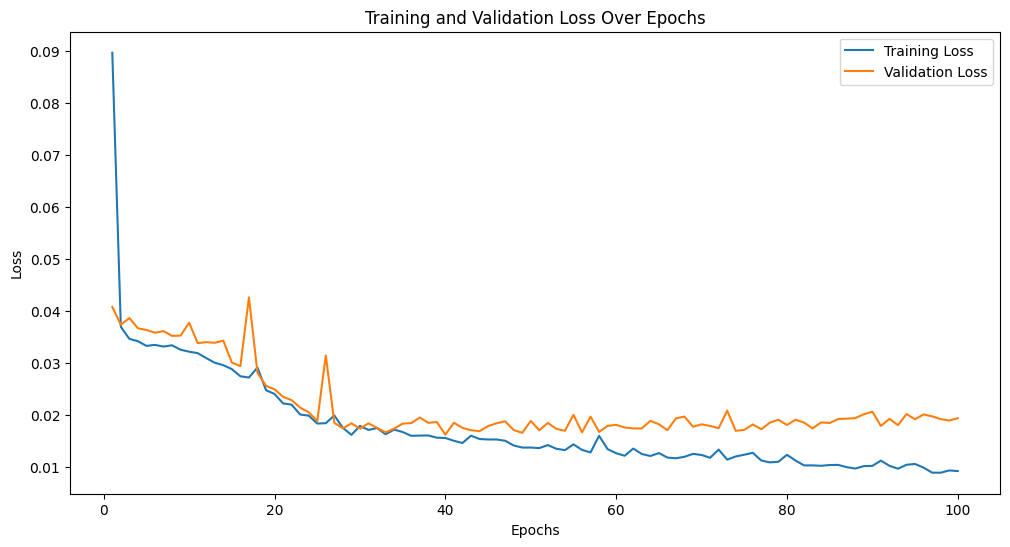

7/7 [==============================] - 1s 9ms/step


In [ ]:
# Train the model
history = model_2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions and inverse transform
y_pred_2 = model_2.predict(X_test)
y_pred_inv_2 = scaler_target.inverse_transform(y_pred_2)
y_test_inv_2 = scaler_target.inverse_transform(y_test.reshape(-1, 1))

RMSE: 127.72
MAE: 101.78


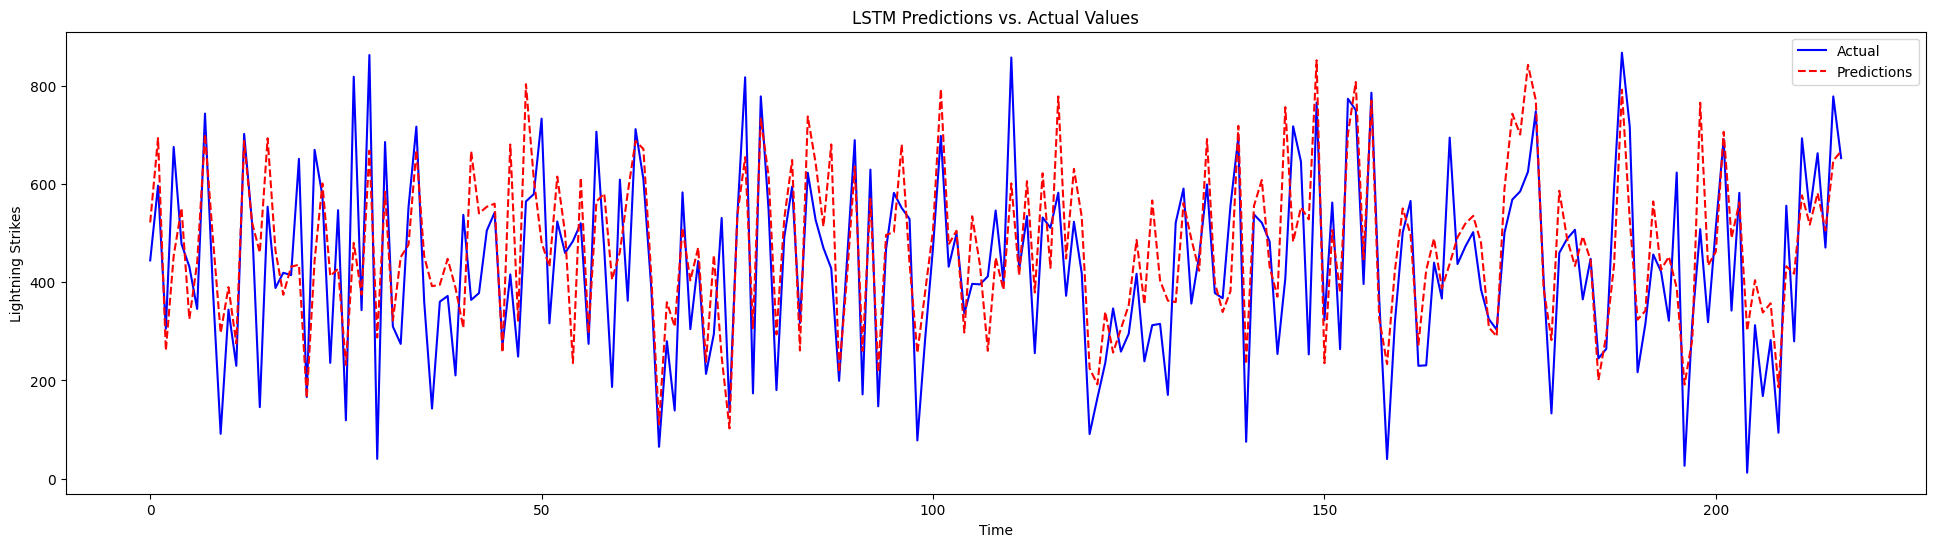

In [ ]:
# 1. Evaluate model performance
rmse = mean_squared_error(y_test_inv_2, y_pred_inv_2, squared=False)  # RMSE
mae = mean_absolute_error(y_test_inv_2, y_pred_inv_2)  # MAE
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 2. Visualize predictions vs actual values
plt.figure(figsize=(24, 6))
plt.plot(y_test_inv_2[:400], label='Actual', color='blue')
plt.plot(y_pred_inv_2[:300], label='Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs. Actual Values")
plt.xlabel('Time')
plt.ylabel('Lightning Strikes')
plt.legend()
plt.show()

# **Modelo 3**

In [ ]:
# Creating lagged features for temperature and humidity
df_combinado['temp_lag1'] = df_combinado['Temperatura'].shift(1)
df_combinado['humidity_lag1'] = df_combinado['Humedad'].shift(1)

# Adding more
n_lags = 5
for i in range(2, n_lags + 1):
    df_combinado[f'temp_lag{i}'] = df_combinado['Temperatura'].shift(i)
    df_combinado[f'humidity_lag{i}'] = df_combinado['Humedad'].shift(i)
# Desplaza los valores de la columna 'Temperatura' una posición hacia abajo.
# cada valor en la columna 'temp_lag1' será el valor de 'Temperatura'
# del día anterior (o de la fila anterior).
# Feature selection and target variable definition


# Data scaling
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Create time series sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(features_scaled, n_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100
28/28 [==============================] - 6s 57ms/step - loss: 0.1133 - val_loss: 0.0400
Epoch 2/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0387 - val_loss: 0.0354
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.0322 - val_loss: 0.0341
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0323 - val_loss: 0.0341
Epoch 5/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0311 - val_loss: 0.0348
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0325 - val_loss: 0.0345
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0311 - val_loss: 0.0326
Epoch 8/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0302 - val_loss: 0.0327
Epoch 9/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0295 - val_loss: 0.0316
Epoch 10/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0284 - val_loss: 0.0316

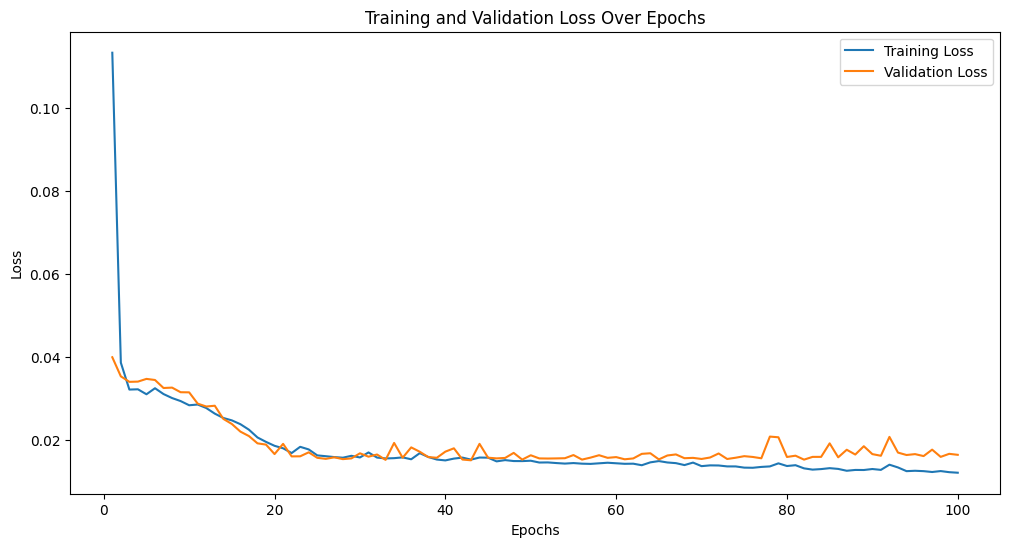

7/7 [==============================] - 1s 6ms/step


In [ ]:
# Define and build LSTM model
model_3 = Sequential()
model_3.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, features_scaled.shape[1])))
model_3.add(LSTM(50))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mse')

# Train the model
history = model_3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions and inverse transform
y_pred_3 = model_3.predict(X_test)
y_pred_inv_3 = scaler_target.inverse_transform(y_pred_3)
y_test_inv_3 = scaler_target.inverse_transform(y_test.reshape(-1, 1))

RMSE: 118.06
MAE: 91.34


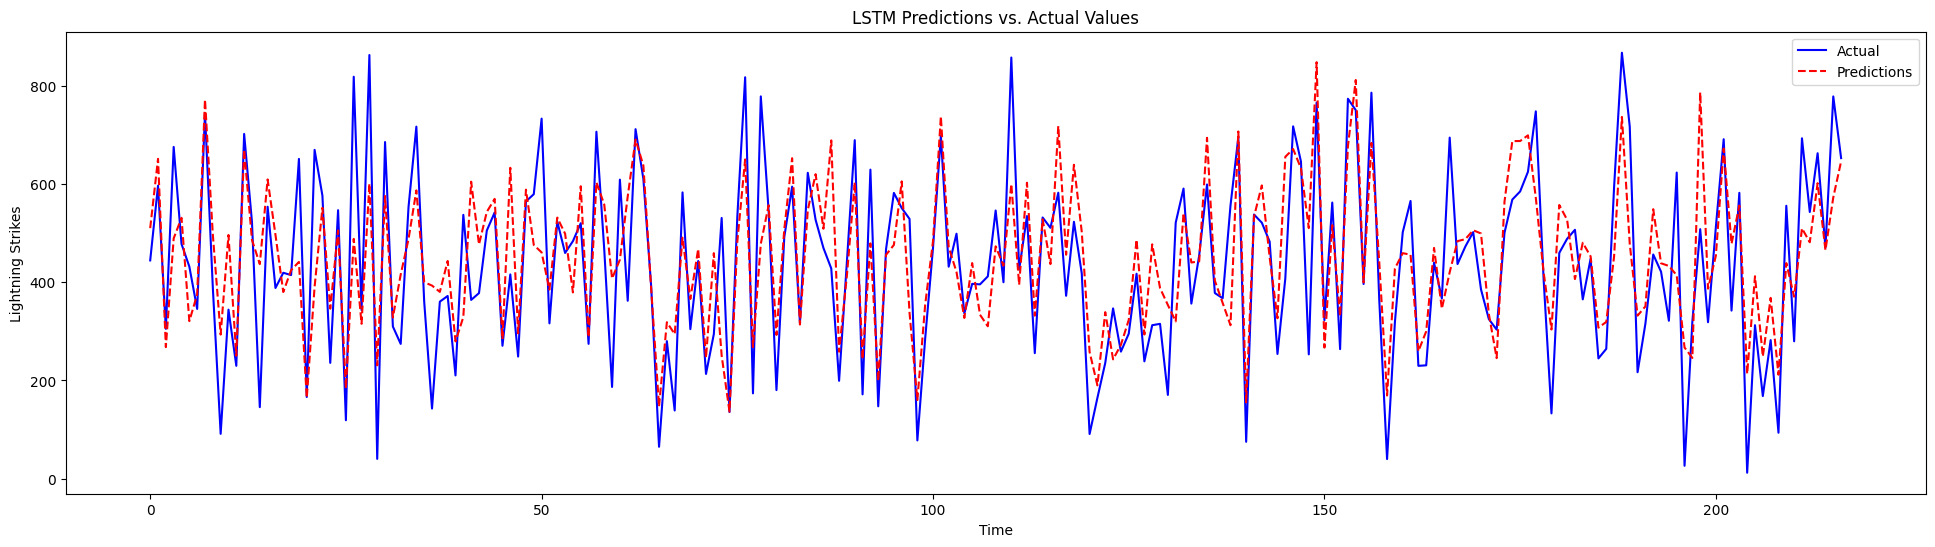

In [ ]:
# 1. Evaluate model performance
rmse = mean_squared_error(y_test_inv_3, y_pred_inv_3, squared=False)  # RMSE
mae = mean_absolute_error(y_test_inv_3, y_pred_inv_3)  # MAE
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 2. Visualize predictions vs actual values
plt.figure(figsize=(24, 6))
plt.plot(y_test_inv_3[:400], label='Actual', color='blue')
plt.plot(y_pred_inv_3[:300], label='Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs. Actual Values")
plt.xlabel('Time')
plt.ylabel('Lightning Strikes')
plt.legend()
plt.show()

# Modelo 4

Epoch 1/100
37/37 [==============================] - 5s 47ms/step - loss: 0.0955 - val_loss: 0.0419
Epoch 2/100
37/37 [==============================] - 1s 22ms/step - loss: 0.0269 - val_loss: 0.0291
Epoch 3/100
37/37 [==============================] - 1s 19ms/step - loss: 0.0232 - val_loss: 0.0267
Epoch 4/100
37/37 [==============================] - 1s 14ms/step - loss: 0.0220 - val_loss: 0.0253
Epoch 5/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0210 - val_loss: 0.0250
Epoch 6/100
37/37 [==============================] - 1s 13ms/step - loss: 0.0202 - val_loss: 0.0240
Epoch 7/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0195 - val_loss: 0.0227
Epoch 8/100
37/37 [==============================] - 1s 14ms/step - loss: 0.0189 - val_loss: 0.0225
Epoch 9/100
37/37 [==============================] - 0s 13ms/step - loss: 0.0175 - val_loss: 0.0214
Epoch 10/100
37/37 [==============================] - 1s 14ms/step - loss: 0.0167 - val_loss: 0.0217

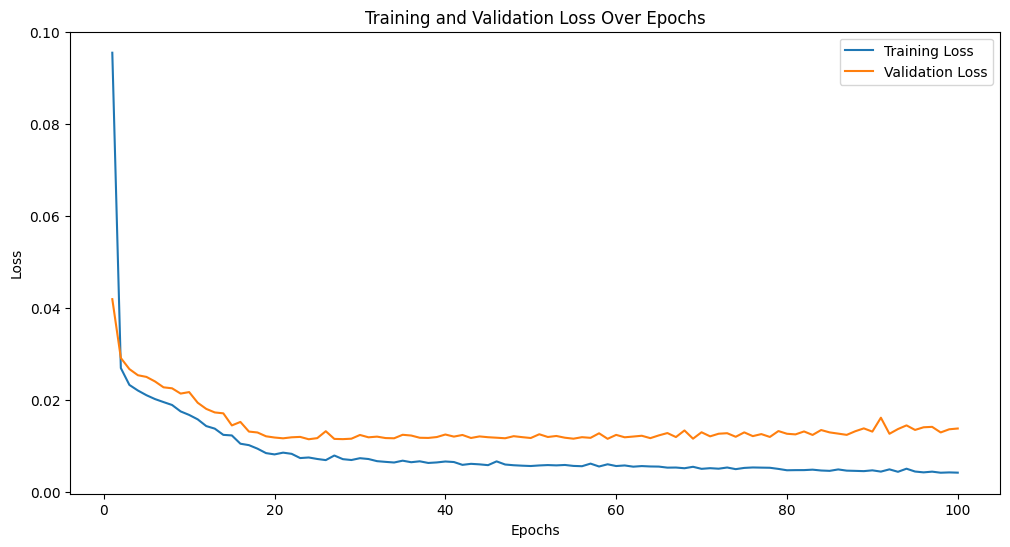

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Asumiendo que ya tienes df_temp_humedad_resampled y df_rayos_resampled como DataFrames preprocesados

# Combinar temperatura, humedad con los datos de incidencia de rayos
df_combinado = pd.concat([df_temp_humedad_resampled, *df_rayos_resampled.values()], axis=1)
df_combinado['Asuncion-Central_Positivo'] = df_combinado['Central_Positivo'] + df_combinado['Asuncion_Positivo']
df_combinado['Asuncion-Central_Negativo'] = df_combinado['Central_Negativo'] + df_combinado['Asuncion_Negativo']

# Normalizar los datos
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)

# Crear características desplazadas para temperatura y humedad
df_combinado['temp_lag1'] = df_combinado['Temperatura'].shift(1)
df_combinado['humidity_lag1'] = df_combinado['Humedad'].shift(1)
n_lags = 5  # Ajusta el número de lags según sea necesario
for i in range(2, n_lags + 1):
    df_combinado[f'temp_lag{i}'] = df_combinado['Temperatura'].shift(i)
    df_combinado[f'humidity_lag{i}'] = df_combinado['Humedad'].shift(i)

# Definir y construir el modelo LSTM
n_steps = 10  # Define el número de pasos de tiempo para el LSTM
features_scaled = df_normalizado.values

X = []
y = []
for i in range(n_steps, len(features_scaled)):
    X.append(features_scaled[i-n_steps:i])
    y.append(features_scaled[i, 0])  # Asumiendo que el objetivo es la primera columna
X = np.array(X)
y = np.array(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Epoch 1/100
36/36 [==============================] - 6s 48ms/step - loss: 0.0861 - val_loss: 0.0362
Epoch 2/100
36/36 [==============================] - 1s 30ms/step - loss: 0.0262 - val_loss: 0.0289
Epoch 3/100
36/36 [==============================] - 1s 30ms/step - loss: 0.0222 - val_loss: 0.0259
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.0216 - val_loss: 0.0253
Epoch 5/100
36/36 [==============================] - 1s 30ms/step - loss: 0.0211 - val_loss: 0.0260
Epoch 6/100
36/36 [==============================] - 1s 30ms/step - loss: 0.0206 - val_loss: 0.0245
Epoch 7/100
36/36 [==============================] - 1s 30ms/step - loss: 0.0205 - val_loss: 0.0272
Epoch 8/100
36/36 [==============================] - 2s 43ms/step - loss: 0.0195 - val_loss: 0.0237
Epoch 9/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0189 - val_loss: 0.0230
Epoch 10/100
36/36 [==============================] - 2s 48ms/step - loss: 0.0177 - val_loss: 0.0228

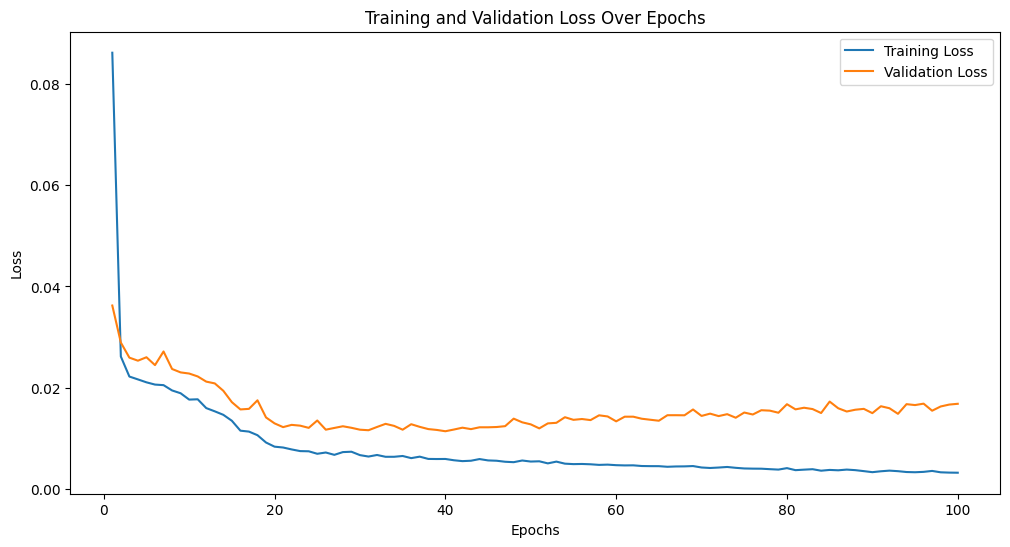

9/9 [==============================] - 1s 10ms/step
RMSE: 3.57
MAE: 2.84


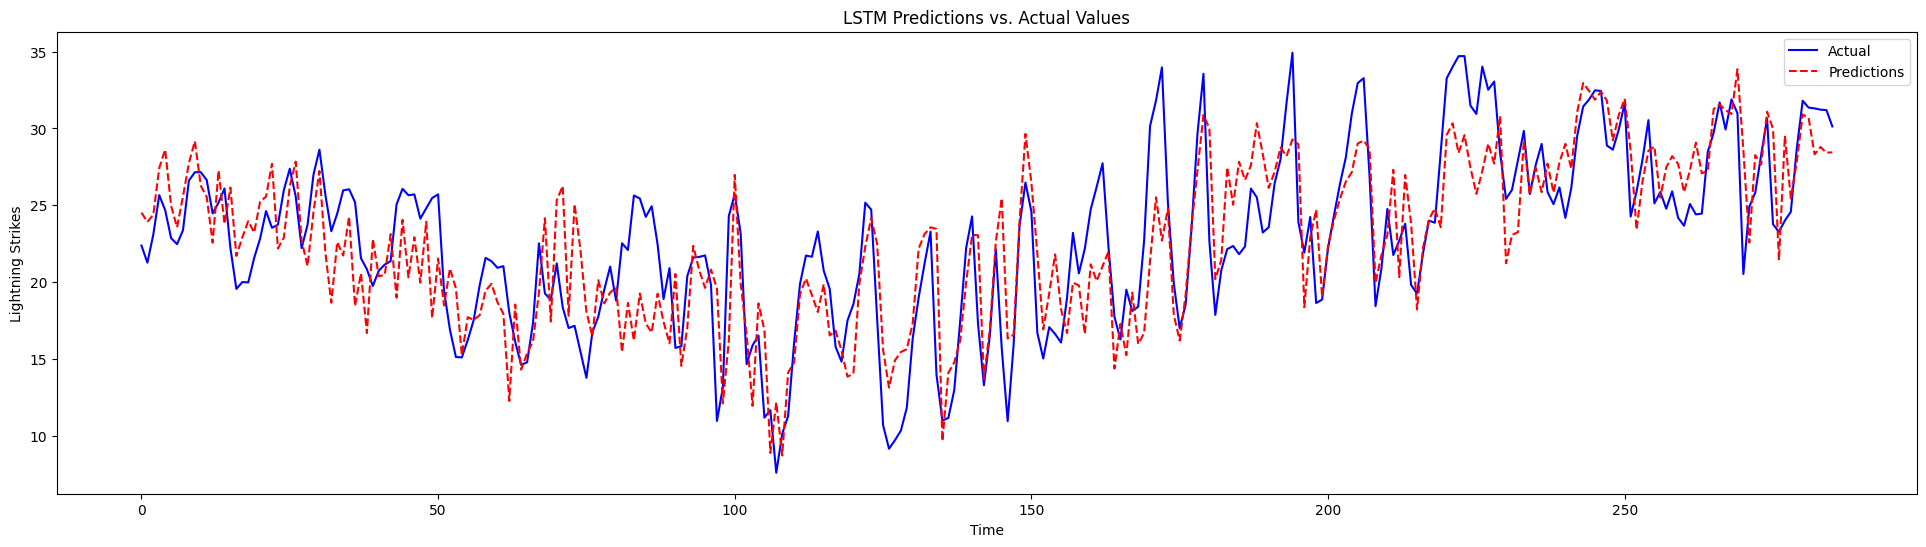

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Asumiendo que ya tienes df_temp_humedad_resampled y df_rayos_resampled como DataFrames preprocesados

# Combinar temperatura, humedad con los datos de incidencia de rayos
df_combinado = pd.concat([df_temp_humedad_resampled, *df_rayos_resampled.values()], axis=1)
df_combinado['Asuncion-Central_Positivo'] = df_combinado['Central_Positivo'] + df_combinado['Asuncion_Positivo']
df_combinado['Asuncion-Central_Negativo'] = df_combinado['Central_Negativo'] + df_combinado['Asuncion_Negativo']

# Normalizar los datos
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_combinado), columns=df_combinado.columns, index=df_combinado.index)

# Crear características desplazadas para temperatura y humedad
df_combinado['temp_lag1'] = df_combinado['Temperatura'].shift(1)
df_combinado['humidity_lag1'] = df_combinado['Humedad'].shift(1)
n_lags = 5
for i in range(2, n_lags + 1):
    df_combinado[f'temp_lag{i}'] = df_combinado['Temperatura'].shift(i)
    df_combinado[f'humidity_lag{i}'] = df_combinado['Humedad'].shift(i)

# Definir y construir el modelo LSTM
n_steps = 30  # Define el número de pasos de tiempo para el LSTM
features_scaled = df_normalizado.values

X = []
y = []
for i in range(n_steps, len(features_scaled)):
    X.append(features_scaled[i-n_steps:i])
    y.append(features_scaled[i, 0])  # Asumiendo que el objetivo es la primera columna
X = np.array(X)
y = np.array(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Extraer el historial de entrenamiento
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Graficar las curvas de pérdida de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Hacer predicciones y transformar inversamente
y_pred = model.predict(X_test)

# Solo invertir la transformación de la columna de interés
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.min_, scaler_target.scale_ = scaler.min_[0], scaler.scale_[0]

y_pred_inv = scaler_target.inverse_transform(y_pred_reshaped)
y_test_inv = scaler_target.inverse_transform(y_test_reshaped)

# Evaluar el rendimiento del modelo
rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(24, 6))
plt.plot(y_test_inv[:400], label='Actual', color='blue')
plt.plot(y_pred_inv[:300], label='Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs. Actual Values")
plt.xlabel('Time')
plt.ylabel('Lightning Strikes')
plt.legend()
plt.show()

# **Predecir 7 dias**

In [ ]:
# Data scaling
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Create time series sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(features_scaled, n_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100
27/27 [==============================] - 6s 69ms/step - loss: 0.0934 - val_loss: 0.0414
Epoch 2/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0338 - val_loss: 0.0353
Epoch 3/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0316 - val_loss: 0.0343
Epoch 4/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0310 - val_loss: 0.0367
Epoch 5/100
27/27 [==============================] - 1s 30ms/step - loss: 0.0305 - val_loss: 0.0325
Epoch 6/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0298 - val_loss: 0.0327
Epoch 7/100
27/27 [==============================] - 1s 32ms/step - loss: 0.0305 - val_loss: 0.0314
Epoch 8/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0289 - val_loss: 0.0309
Epoch 9/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0287 - val_loss: 0.0315
Epoch 10/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0284 - val_loss: 0.0331

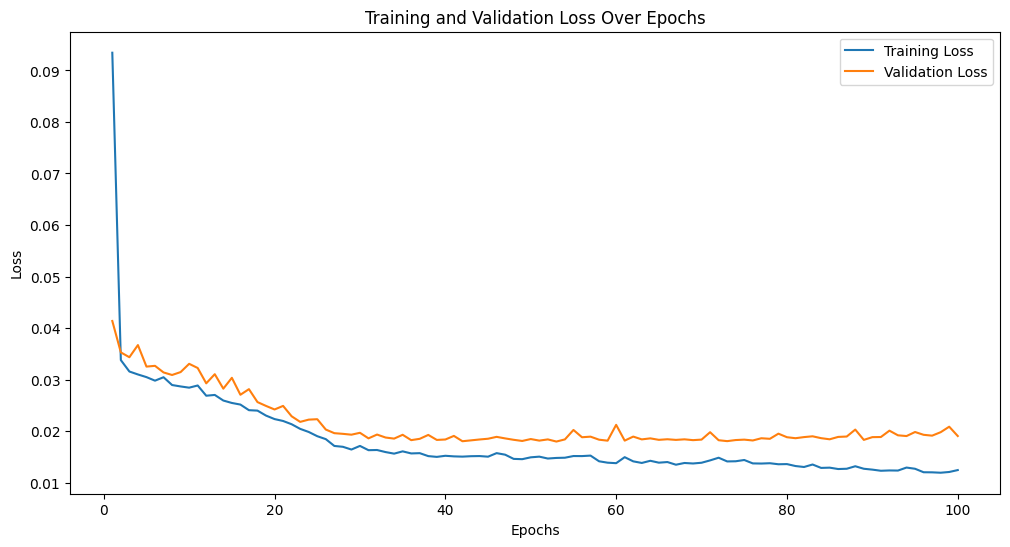

7/7 [==============================] - 1s 9ms/step
RMSE: 126.47
MAE: 98.94


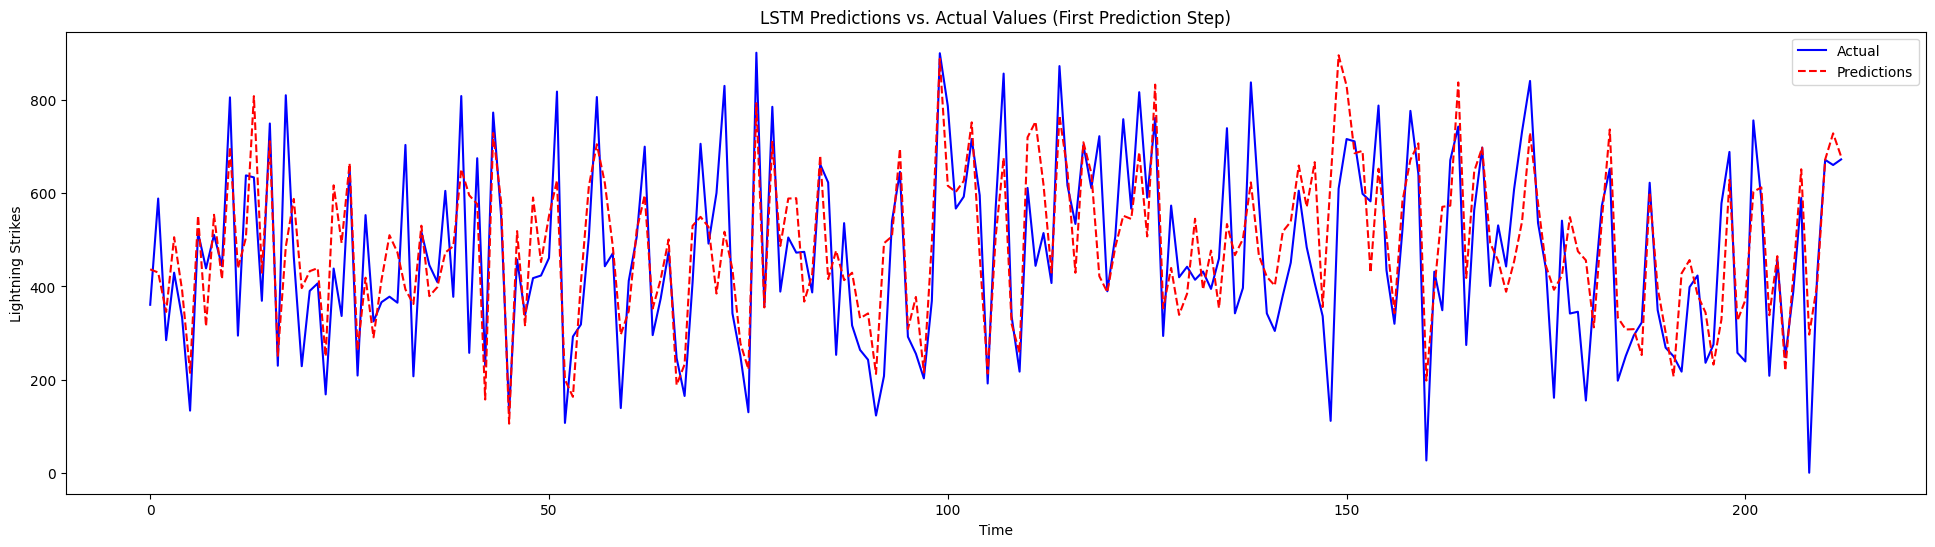

In [ ]:
# Define and build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, features_scaled.shape[1])))
model.add(LSTM(50))
model.add(Dense(7))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Reformatear y_test
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_target.inverse_transform(y_test)

# Evaluar el rendimiento del modelo
y_pred_inv_first_step = y_pred_inv[:, 0].reshape(-1, 1)

# Calcular el RMSE y MAE
rmse = mean_squared_error(y_test_inv, y_pred_inv_first_step, squared=False)
mae = mean_absolute_error(y_test_inv, y_pred_inv_first_step)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Visualizar las predicciones vs valores reales
plt.figure(figsize=(24, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(y_pred_inv_first_step, label='Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs. Actual Values (First Prediction Step)")
plt.xlabel('Time')
plt.ylabel('Lightning Strikes')
plt.legend()
plt.show()


# Predecir 14 dias

In [ ]:
# Data scaling
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Create time series sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(features_scaled, n_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100
54/54 [==============================] - 7s 53ms/step - loss: 0.0886 - val_loss: 0.0400
Epoch 2/100
54/54 [==============================] - 2s 42ms/step - loss: 0.0352 - val_loss: 0.0360
Epoch 3/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0319 - val_loss: 0.0390
Epoch 4/100
54/54 [==============================] - 1s 28ms/step - loss: 0.0327 - val_loss: 0.0336
Epoch 5/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0305 - val_loss: 0.0329
Epoch 6/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0303 - val_loss: 0.0316
Epoch 7/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 8/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0285 - val_loss: 0.0343
Epoch 9/100
54/54 [==============================] - 2s 30ms/step - loss: 0.0283 - val_loss: 0.0295
Epoch 10/100
54/54 [==============================] - 2s 41ms/step - loss: 0.0272 - val_loss: 0.0319

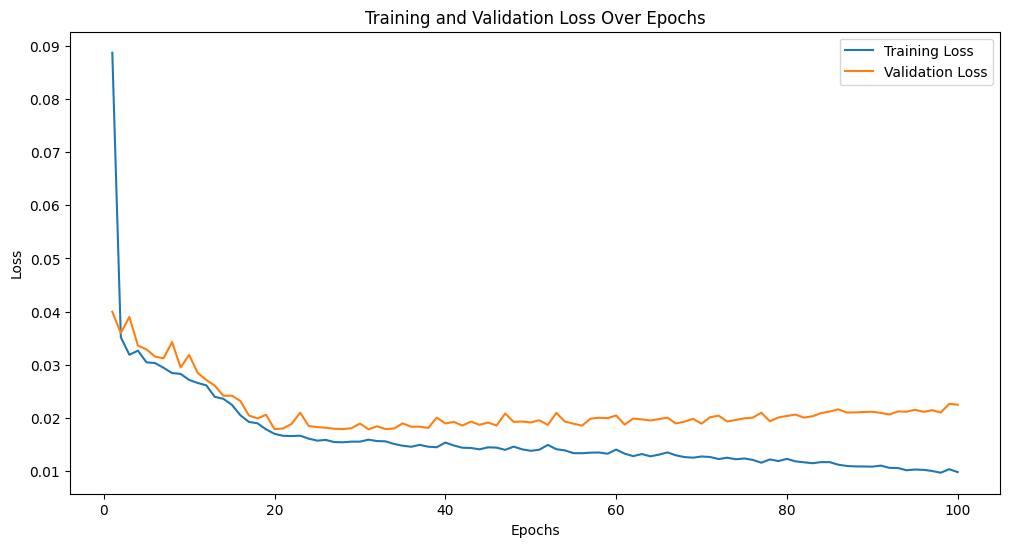

7/7 [==============================] - 1s 13ms/step
RMSE: 138.18
MAE: 105.59


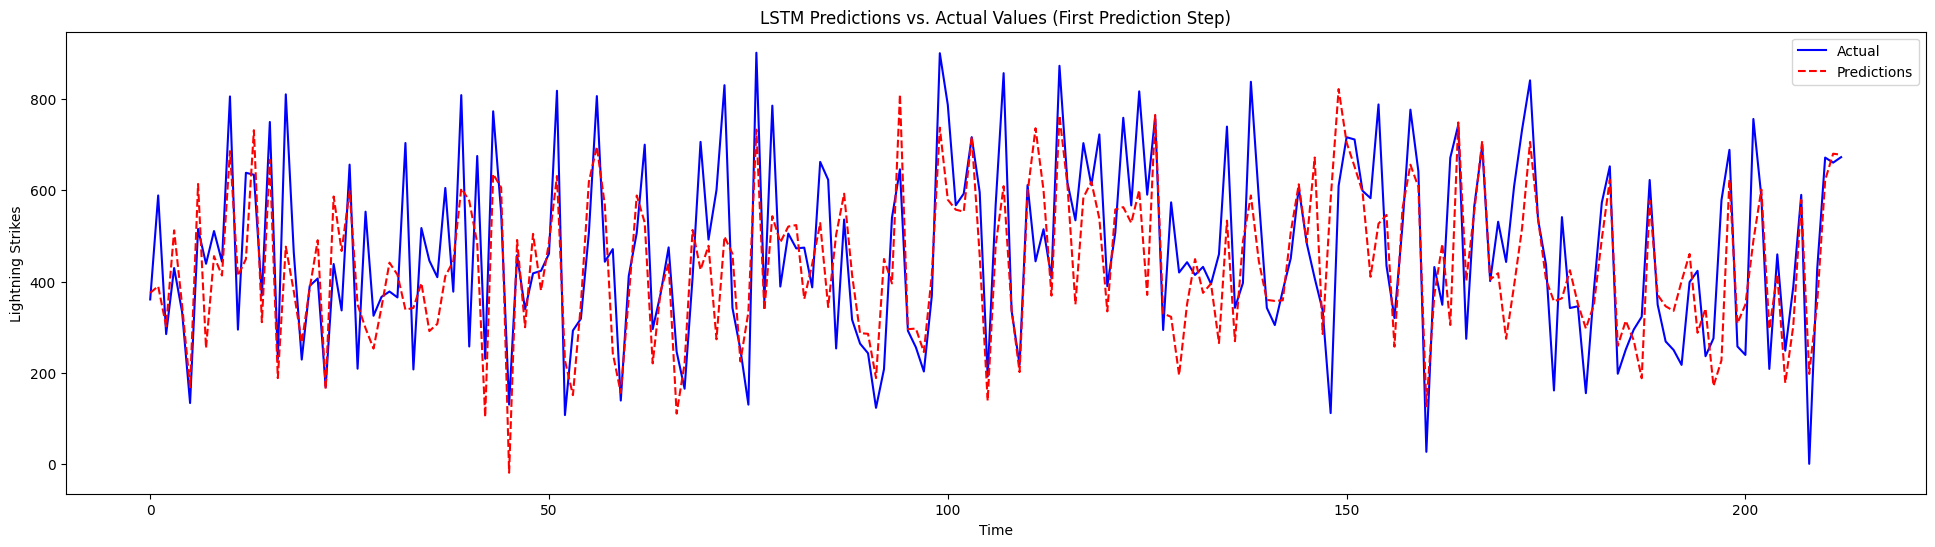

In [ ]:
# Define and build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, features_scaled.shape[1])))
model.add(LSTM(50))
model.add(Dense(14))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Reformatear y_test
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_target.inverse_transform(y_test)

# Evaluar el rendimiento del modelo
y_pred_inv_first_step = y_pred_inv[:, 0].reshape(-1, 1)

# Calcular el RMSE y MAE
rmse = mean_squared_error(y_test_inv, y_pred_inv_first_step, squared=False)
mae = mean_absolute_error(y_test_inv, y_pred_inv_first_step)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Visualizar las predicciones vs valores reales
plt.figure(figsize=(24, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(y_pred_inv_first_step, label='Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs. Actual Values (First Prediction Step)")
plt.xlabel('Time')
plt.ylabel('Lightning Strikes')
plt.legend()
plt.show()


# 30 dias

In [ ]:
# Data scaling
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Create time series sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(features_scaled, n_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100
54/54 [==============================] - 5s 43ms/step - loss: 0.0998 - val_loss: 0.0438
Epoch 2/100
54/54 [==============================] - 2s 41ms/step - loss: 0.0354 - val_loss: 0.0379
Epoch 3/100
54/54 [==============================] - 2s 39ms/step - loss: 0.0330 - val_loss: 0.0359
Epoch 4/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0307 - val_loss: 0.0325
Epoch 5/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0306 - val_loss: 0.0351
Epoch 6/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0299 - val_loss: 0.0327
Epoch 7/100
54/54 [==============================] - 1s 28ms/step - loss: 0.0290 - val_loss: 0.0303
Epoch 8/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0287 - val_loss: 0.0314
Epoch 9/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0274 - val_loss: 0.0284
Epoch 10/100
54/54 [==============================] - 2s 32ms/step - loss: 0.0263 - val_loss: 0.0276

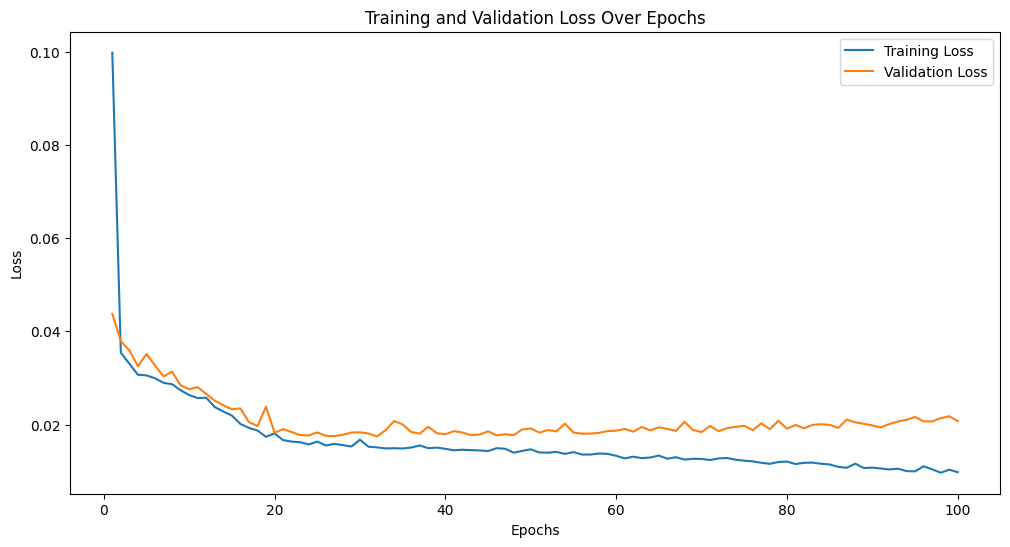

7/7 [==============================] - 1s 14ms/step
RMSE: 132.52
MAE: 101.71


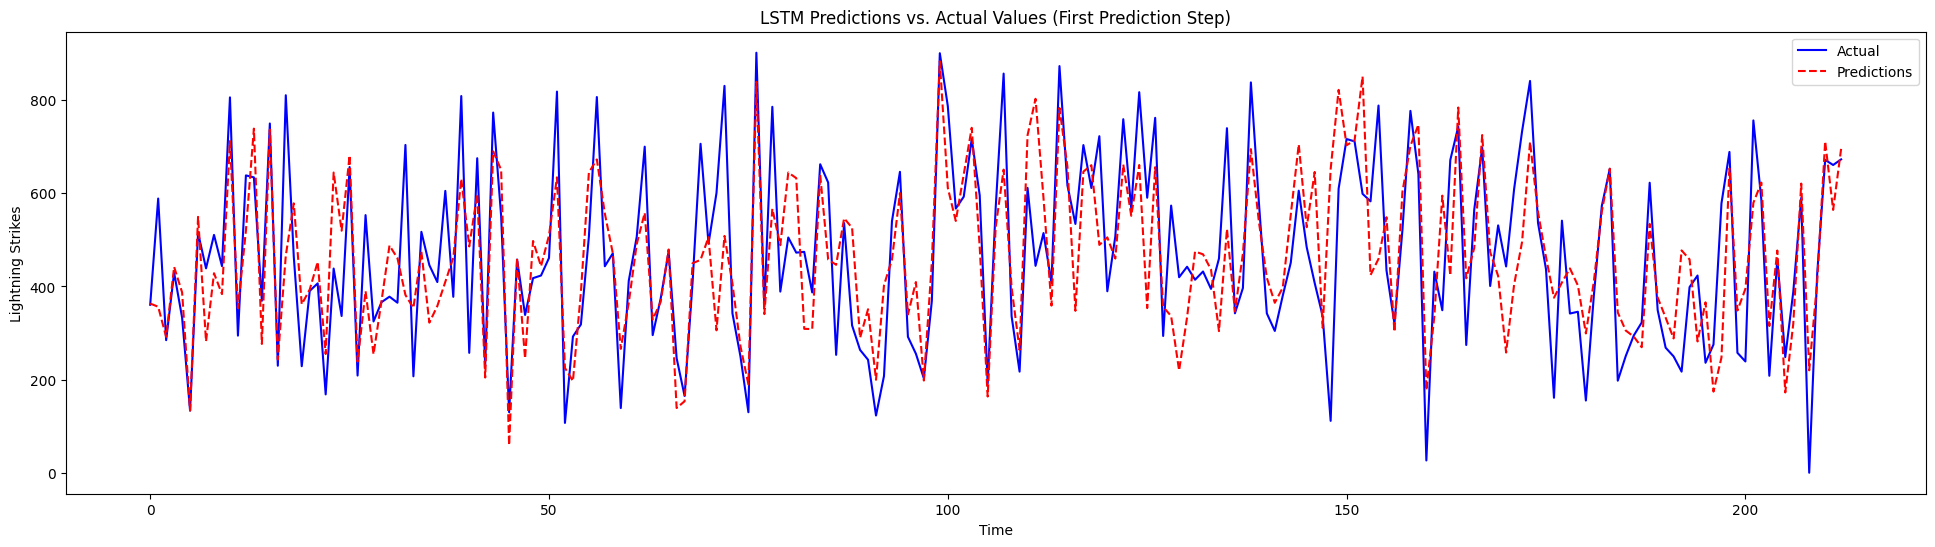

In [ ]:
# Define and build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, features_scaled.shape[1])))
model.add(LSTM(50))
model.add(Dense(30))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Reformatear y_test
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_target.inverse_transform(y_test)

# Evaluar el rendimiento del modelo
y_pred_inv_first_step = y_pred_inv[:, 0].reshape(-1, 1)

# Calcular el RMSE y MAE
rmse = mean_squared_error(y_test_inv, y_pred_inv_first_step, squared=False)
mae = mean_absolute_error(y_test_inv, y_pred_inv_first_step)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Visualizar las predicciones vs valores reales
plt.figure(figsize=(24, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(y_pred_inv_first_step, label='Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs. Actual Values (First Prediction Step)")
plt.xlabel('Time')
plt.ylabel('Lightning Strikes')
plt.legend()
plt.show()
